In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import sys
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
base_dir = '/content/drive/MyDrive/BagOfLies'

In [ ]:
df = pd.read_csv(f'{base_dir}/Audio_Finalized.csv')
df.head()

,eGeMAPSv02_LowLevelDescriptors__Loudness_sma3_max,eGeMAPSv02_LowLevelDescriptors__alphaRatio_sma3_max,eGeMAPSv02_LowLevelDescriptors__hammarbergIndex_sma3_max,eGeMAPSv02_LowLevelDescriptors__slope0-500_sma3_max,eGeMAPSv02_LowLevelDescriptors__slope500-1500_sma3_max,eGeMAPSv02_LowLevelDescriptors__spectralFlux_sma3_max,eGeMAPSv02_LowLevelDescriptors__mfcc1_sma3_max,eGeMAPSv02_LowLevelDescriptors__mfcc2_sma3_max,eGeMAPSv02_LowLevelDescriptors__mfcc3_sma3_max,eGeMAPSv02_LowLevelDescriptors__mfcc4_sma3_max,eGeMAPSv02_LowLevelDescriptors__F0semitoneFrom27.5Hz_sma3nz_max,eGeMAPSv02_LowLevelDescriptors__jitterLocal_sma3nz_max,eGeMAPSv02_LowLevelDescriptors__shimmerLocaldB_sma3nz_max,eGeMAPSv02_LowLevelDescriptors__HNRdBACF_sma3nz_max,eGeMAPSv02_LowLevelDescriptors__logRelF0-H1-H2_sma3nz_max,eGeMAPSv02_LowLevelDescriptors__logRelF0-H1-A3_sma3nz_max,eGeMAPSv02_LowLevelDescriptors__F1frequency_sma3nz_max,eGeMAPSv02_LowLevelDescriptors__F1bandwidth_sma3nz_max,eGeMAPSv02_LowLevelDescriptors__F1amplitudeLogRelF0_sma3nz_max,eGeMAPSv02_LowLevelDescriptors__F2frequency_sma3nz_max,eGeMAPSv02_LowLevelDescriptors__F2bandwidth_sma3nz_max,eGeMAPSv02_LowLevelDescriptors__F2amplitudeLogRelF0_sma3nz_max,eGeMAPSv02_LowLevelDescriptors__F3frequency_sma3nz_max,eGeMAPSv02_LowLevelDescriptors__F3bandwidth_sma3nz_max,eGeMAPSv02_LowLevelDescriptors__F3amplitudeLogRelF0_sma3nz_max,ComParE2016_LowLevelDescriptors__F0final_sma_max,ComParE2016_LowLevelDescriptors__voicingFinalUnclipped_sma_max,ComParE2016_LowLevelDescriptors__jitterLocal_sma_max,ComParE2016_LowLevelDescriptors__jitterDDP_sma_max,ComParE2016_LowLevelDescriptors__shimmerLocal_sma_max,ComParE2016_LowLevelDescriptors__logHNR_sma_max,ComParE2016_LowLevelDescriptors__audspec_lengthL1norm_sma_max,ComParE2016_LowLevelDescriptors__audspecRasta_lengthL1norm_sma_max,ComParE2016_LowLevelDescriptors__pcm_RMSenergy_sma_max,ComParE2016_LowLevelDescriptors__pcm_zcr_sma_max,ComParE2016_LowLevelDescriptors__audSpec_Rfilt_sma[0]_max,ComParE2016_LowLevelDescriptors__audSpec_Rfilt_sma[1]_max,ComParE2016_LowLevelDescriptors__audSpec_Rfilt_sma[2]_max,ComParE2016_LowLevelDescriptors__audSpec_Rfilt_sma[3]_max,ComParE2016_LowLevelDescriptors__audSpec_Rfilt_sma[4]_max,...,eGeMAPSv02_Functionals__F2bandwidth_sma3nz_stddevNorm,eGeMAPSv02_Functionals__F2amplitudeLogRelF0_sma3nz_amean,eGeMAPSv02_Functionals__F2amplitudeLogRelF0_sma3nz_stddevNorm,eGeMAPSv02_Functionals__F3frequency_sma3nz_amean,eGeMAPSv02_Functionals__F3frequency_sma3nz_stddevNorm,eGeMAPSv02_Functionals__F3bandwidth_sma3nz_amean,eGeMAPSv02_Functionals__F3bandwidth_sma3nz_stddevNorm,eGeMAPSv02_Functionals__F3amplitudeLogRelF0_sma3nz_amean,eGeMAPSv02_Functionals__F3amplitudeLogRelF0_sma3nz_stddevNorm,eGeMAPSv02_Functionals__alphaRatioV_sma3nz_amean,eGeMAPSv02_Functionals__alphaRatioV_sma3nz_stddevNorm,eGeMAPSv02_Functionals__hammarbergIndexV_sma3nz_amean,eGeMAPSv02_Functionals__hammarbergIndexV_sma3nz_stddevNorm,eGeMAPSv02_Functionals__slopeV0-500_sma3nz_amean,eGeMAPSv02_Functionals__slopeV0-500_sma3nz_stddevNorm,eGeMAPSv02_Functionals__slopeV500-1500_sma3nz_amean,eGeMAPSv02_Functionals__slopeV500-1500_sma3nz_stddevNorm,eGeMAPSv02_Functionals__spectralFluxV_sma3nz_amean,eGeMAPSv02_Functionals__spectralFluxV_sma3nz_stddevNorm,eGeMAPSv02_Functionals__mfcc1V_sma3nz_amean,eGeMAPSv02_Functionals__mfcc1V_sma3nz_stddevNorm,eGeMAPSv02_Functionals__mfcc2V_sma3nz_amean,eGeMAPSv02_Functionals__mfcc2V_sma3nz_stddevNorm,eGeMAPSv02_Functionals__mfcc3V_sma3nz_amean,eGeMAPSv02_Functionals__mfcc3V_sma3nz_stddevNorm,eGeMAPSv02_Functionals__mfcc4V_sma3nz_amean,eGeMAPSv02_Functionals__mfcc4V_sma3nz_stddevNorm,eGeMAPSv02_Functionals__alphaRatioUV_sma3nz_amean,eGeMAPSv02_Functionals__hammarbergIndexUV_sma3nz_amean,eGeMAPSv02_Functionals__slopeUV0-500_sma3nz_amean,eGeMAPSv02_Functionals__slopeUV500-1500_sma3nz_amean,eGeMAPSv02_Functionals__spectralFluxUV_sma3nz_amean,eGeMAPSv02_Functionals__loudnessPeaksPerSec,eGeMAPSv02_Functionals__VoicedSegmentsPerSec,eGeMAPSv02_Functionals__Mean

### Model Defined

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,f_classif,mutual_info_classif
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
SEED = 42

grid_params={
    'Random Forest':[{'n_estimators': [200, 500],
                    'max_features': ['auto', 'sqrt', 'log2'],
                    'max_depth' : [4,5,6,7,8],
                    'criterion' :['gini', 'entropy']},
                    RandomForestClassifier(n_jobs=1,random_state=SEED)],
    'Decision Tree':[{"max_depth": [3, 5, 7, 9, 11, 13]},
                    DecisionTreeClassifier(random_state=SEED,
                    class_weight='balanced')],
    'SVM':[{"C": [0.001, 0.01, 0.1, 1.],
            "kernel": ["linear", "poly", "rbf", "sigmoid"],
            "gamma": ["scale", "auto"]},
            SVC(random_state=SEED,
            class_weight="balanced",
            probability=True)],
    'Logistic Regression':[{"C": [0.001, 0.01, 0.1, 1.],
                            "penalty": ["l1", "l2"]},
                           LogisticRegression(random_state=SEED,
                                class_weight="balanced",
                                solver="liblinear")],
    'KNN':[{"weights": ["uniform", "distance"],
            'n_neighbors':[5,10,8,7,15,20,13,25]},
           KNeighborsClassifier()]
}

In [ ]:
def classification(X, unScaledData, y, label, cross_validated_data):
    for model,params in grid_params.items():
        applied_model = GridSearchCV(
                params[1], 
                params[0], 
                cv=cv_split,
                scoring='accuracy')
        if(model=='Decision Tree' or model=='Random Forest'):
            applied_model.fit(unScaledData.values, y.values)
        else:
            applied_model.fit(X, y.values)

        print('-----')
        print(f'For {label} features')
        print('- - - -')
        print(f'Applied Model:{model}\nBest parameters {applied_model.best_params_}')
        print(f'Mean cross-validated accuracy score of the best_estimator: {applied_model.best_score_:.2f}')
        cross_validated_accuracy=round(applied_model.best_score_ * 100,2)
        if model not in cross_validated_data['model']:
            cross_validated_data['model'].append(model)
        cross_validated_data[f'result_{label}'].append([applied_model.best_params_,cross_validated_accuracy])
        print('-----')

In [ ]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

### eGeMAPSv02_Functionals

#### eGeMAPSv02_Functionals Features Scalling



In [ ]:
columns = [column for column in df.columns if ('eGeMAPSv02_Functionals' in column) or ('label' in column)]
eGeMAPSv02_Functionals = df[columns]
columns = [column.replace('eGeMAPSv02_Functionals__', '') for column in eGeMAPSv02_Functionals.columns]
eGeMAPSv02_Functionals.columns = columns
eGeMAPSv02_Functionals.head()

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,loudness_sma3_amean,loudness_sma3_stddevNorm,loudness_sma3_percentile20.0,loudness_sma3_percentile50.0,loudness_sma3_percentile80.0,loudness_sma3_pctlrange0-2,loudness_sma3_meanRisingSlope,loudness_sma3_stddevRisingSlope,loudness_sma3_meanFallingSlope,loudness_sma3_stddevFallingSlope,spectralFlux_sma3_amean,spectralFlux_sma3_stddevNorm,mfcc1_sma3_amean,mfcc1_sma3_stddevNorm,mfcc2_sma3_amean,mfcc2_sma3_stddevNorm,mfcc3_sma3_amean,mfcc3_sma3_stddevNorm,mfcc4_sma3_amean,mfcc4_sma3_stddevNorm,jitterLocal_sma3nz_amean,jitterLocal_sma3nz_stddevNorm,shimmerLocaldB_sma3nz_amean,shimmerLocaldB_sma3nz_stddevNorm,HNRdBACF_sma3nz_amean,HNRdBACF_sma3nz_stddevNorm,logRelF0-H1-H2_sma3nz_amean,logRelF0-H1-H2_sma3nz_stddevNorm,logRelF0-H1-A3_sma3nz_amean,logRelF0-H1-A3_sma3nz_stddevNorm,...,F2bandwidth_sma3nz_stddevNorm,F2amplitudeLogRelF0_sma3nz_amean,F2amplitudeLogRelF0_sma3nz_stddevNorm,F3frequency_sma3nz_amean,F3frequency_sma3nz_stddevNorm,F3bandwidth_sma3nz_amean,F3bandwidth_sma3nz_stddevNorm,F3amplitudeLogRelF0_sma3nz_amean,F3amplitudeLogRelF0_sma3nz_stddevNorm,alphaRatioV_sma3nz_amean,alphaRatioV_sma3nz_stddevNorm,hammarbergIndexV_sma3nz_amean,hammarbergIndexV_sma3nz_stddevNorm,slopeV0-500_sma3nz_amean,slopeV0-500_sma3nz_stddevNorm,slopeV500-1500_sma3nz_amean,slopeV500-1500_sma3nz_stddevNorm,spectralFluxV_sma3nz_amean,spectralFluxV_sma3nz_stddevNorm,mfcc1V_sma3nz_amean,mfcc1V_sma3nz_stddevNorm,mfcc2V_sma3nz_amean,mfcc2V_sma3nz_stddevNorm,mfcc3V_sma3nz_amean,mfcc3V_sma3nz_stddevNorm,mfcc4V_sma3nz_amean,mfcc4V_sma3nz_stddevNorm,alphaRatioUV_sma3nz_amean,hammarbergIndexUV_sma3nz_amean,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,label
0,24.249294,0.065325,22.419380,24.465326,25.327332,2.907951,13.398525,8.248862,9.156681,5.553562,0.303006,0.319675,0.212764,0.288424,0.386876,0.174112,1.465702,0.783676,1.021337,0.632534,0.118529,0.414005,34.395150,0.191484,3.809757,1.779782,17.641258,0.314833,-0.755041,-7.623529,0.020442,0.843058,1.297794,0.457537,3.124569,0.417132,8.134088,0.704282,29.244783,0.189512,...,0.203954,-112.309220,-0.759419,2634.5210,0.092579,1001.6569,0.217470,-115.84937,-0.706298,-16.946520,-0.180650,28.346863,0.127519,0.013193,1.510609,-0.008272,-0.823769,0.114976,0.408528,36.627167,0.092453,2.410513,2.330226,18.308600,0.299841,-2.127711,-2.556060,-16.038200,26.193890,0.010608,-0.006026,0.124790,2.331002,3.169014,0.145185,0.139930,0.150370,0.156240,-33.855396,1
1,23.560852,0.069756,22.263803,22.439530,25.325338,3.061535,39.151714,32.712086,31.320053,37.496990,0.296526,0.387851,0.202209,0.282189,0.387562,0.185353,1.818094,1.110213,1.004053,0.576318,0.103018,0.429522,32.725307,0.189327,1.541547,5.325375,16.283360,0.363286,-2.374255,-2.259740,0.028330,0.932207,1.398934,0.472147,2.434247,0.461301,9.090362,1.034201,26.771160,0.246397,...,0.194773,-121.302890,-0.689930,2739.8909,0.101219,1021.8584,0.194035,-124.62262,-0.642268,-14.697520,-0.246329,25.936240,0.148550,0.014683,1.044913,-0.005113,-1.394369,0.093036,0.462325,34.717310,0.112194,0.954662,8.398816,15.322222,0.384335,-2.531579,-2.194637,-14.115194,23.943686,0.017484,-0.003136,0.113236,2.013423,3.783784,0.106429,0.086198,0.132759,0.190424,-35.328030,0
2,26.160023,0.195289,22.356808,23.428154,27.394037,5.037229,341.034500,489.176060,12.639351,9.763187,0.323906,0.507350,0.193655,0.263887,0.446650,0.252995,2.027791,1.374486,1.901431,2.488861,0.119419

In [ ]:
unScaledData__eGeMAPSv02_Functionals = eGeMAPSv02_Functionals.drop('label', axis=1)

X_eGeMAPSv02_Functionals = eGeMAPSv02_Functionals.drop('label', axis=1)
y = df.iloc[:, -1]

In [ ]:
scaler = StandardScaler()
scaler.fit(X_eGeMAPSv02_Functionals)
scaled_features_eGeMAPSv02_Functionals = scaler.transform(X_eGeMAPSv02_Functionals)
scaled_features_eGeMAPSv02_Functionals

X_eGeMAPSv02_Functionals = pd.DataFrame(scaled_features_eGeMAPSv02_Functionals, columns=X_eGeMAPSv02_Functionals.columns)
X_eGeMAPSv02_Functionals.head()

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,loudness_sma3_amean,loudness_sma3_stddevNorm,loudness_sma3_percentile20.0,loudness_sma3_percentile50.0,loudness_sma3_percentile80.0,loudness_sma3_pctlrange0-2,loudness_sma3_meanRisingSlope,loudness_sma3_stddevRisingSlope,loudness_sma3_meanFallingSlope,loudness_sma3_stddevFallingSlope,spectralFlux_sma3_amean,spectralFlux_sma3_stddevNorm,mfcc1_sma3_amean,mfcc1_sma3_stddevNorm,mfcc2_sma3_amean,mfcc2_sma3_stddevNorm,mfcc3_sma3_amean,mfcc3_sma3_stddevNorm,mfcc4_sma3_amean,mfcc4_sma3_stddevNorm,jitterLocal_sma3nz_amean,jitterLocal_sma3nz_stddevNorm,shimmerLocaldB_sma3nz_amean,shimmerLocaldB_sma3nz_stddevNorm,HNRdBACF_sma3nz_amean,HNRdBACF_sma3nz_stddevNorm,logRelF0-H1-H2_sma3nz_amean,logRelF0-H1-H2_sma3nz_stddevNorm,logRelF0-H1-A3_sma3nz_amean,logRelF0-H1-A3_sma3nz_stddevNorm,...,F2bandwidth_sma3nz_amean,F2bandwidth_sma3nz_stddevNorm,F2amplitudeLogRelF0_sma3nz_amean,F2amplitudeLogRelF0_sma3nz_stddevNorm,F3frequency_sma3nz_amean,F3frequency_sma3nz_stddevNorm,F3bandwidth_sma3nz_amean,F3bandwidth_sma3nz_stddevNorm,F3amplitudeLogRelF0_sma3nz_amean,F3amplitudeLogRelF0_sma3nz_stddevNorm,alphaRatioV_sma3nz_amean,alphaRatioV_sma3nz_stddevNorm,hammarbergIndexV_sma3nz_amean,hammarbergIndexV_sma3nz_stddevNorm,slopeV0-500_sma3nz_amean,slopeV0-500_sma3nz_stddevNorm,slopeV500-1500_sma3nz_amean,slopeV500-1500_sma3nz_stddevNorm,spectralFluxV_sma3nz_amean,spectralFluxV_sma3nz_stddevNorm,mfcc1V_sma3nz_amean,mfcc1V_sma3nz_stddevNorm,mfcc2V_sma3nz_amean,mfcc2V_sma3nz_stddevNorm,mfcc3V_sma3nz_amean,mfcc3V_sma3nz_stddevNorm,mfcc4V_sma3nz_amean,mfcc4V_sma3nz_stddevNorm,alphaRatioUV_sma3nz_amean,hammarbergIndexUV_sma3nz_amean,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,-0.323443,-0.532709,-0.366374,-0.151924,-0.353125,-0.090341,-0.764919,-0.774410,-0.659154,-0.631164,0.054825,-0.420843,0.827871,0.224141,-0.115399,-0.261545,-0.329833,-0.433551,-0.197041,-0.238216,0.038370,-0.517431,1.713039,-0.540753,-0.964700,0.053833,1.624777,-1.026630,-0.442454,-0.294998,-1.076657,-0.377327,0.374875,-0.575848,-0.536802,-0.003850,0.390010,-0.138782,0.902875,-0.581410,...,-0.450031,-0.724941,-0.238497,0.163559,-1.715468,0.167724,0.052235,-1.530437,-0.262739,0.183569,-0.196960,0.565264,0.248782,-0.813631,0.360601,0.053967,-0.170160,-0.020161,-0.143051,-0.525374,2.511038,-1.228226,-1.117069,0.064265,1.398177,-0.861864,-0.348441,-0.145398,-0.880334,0.696104,0.341114,-0.668623,0.834274,0.968309,0.636670,-0.582000,-0.536196,-0.296216,-0.358947,0.112957
1,-0.486964,-0.447706,-0.404384,-0.571659,-0.353515,-0.044757,-0.470702,-0.559025,-0.097755,-0.030924,0.005921,-0.070350,0.630034,0.170670,-0.112852,-0.222484,-0.141276,-0.145934,-0.212689,-0.315362,-0.128230,-0.453249,1.188794,-0.556807,-1.652631,0.460770,1.193758,-0.909578,-0.718725,-0.159652,0.284457,-0.156113,1.331947,-0.238633,-0.949363,0.328964,0.641534,-0.052313,0.029372,-0.075856,...,0.115469,-0.933538,-0.544866,0.539528,-0.497973,1.002493,0.469765,-1.977627,-0.570916,0.581047,0.815155,-0.042878,-0.678817,-0.520687,0.438562,0.047971,0.204210,-0.027726,-0.274398,-0.094869,1.631370,-0.957297,-1.479596,0.309224,0.518579,-0.668533,-0.397893,-0.132213,-0.134668,0.001141,0.884912,-0.162751,0.491106,0.346672,1.321739,-0.821827,-0.698508,-0.404627,-0.218332,-0.137212
2,0.130397,1.960522,-0.381661,-0.366821,0.051438,0.541632,2.978158,3.459886,-0.570938,-0.552062,0.212546,0.543992,0.469712,0.013710,0.

#### Accuracy of eGeMAPSv02_Functionals Features (without correlations)

The number of dimensions required to preserve 90% of variance is 22


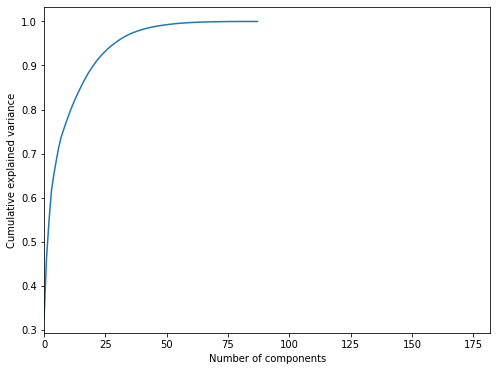

In [ ]:
pca= PCA()
pca.fit(X_eGeMAPSv02_Functionals)
cumsum = np.cumsum(pca.explained_variance_ratio_)
dim = np.argmax(cumsum >= 0.90) + 1
print('The number of dimensions required to preserve 90% of variance is',dim)
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,182,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

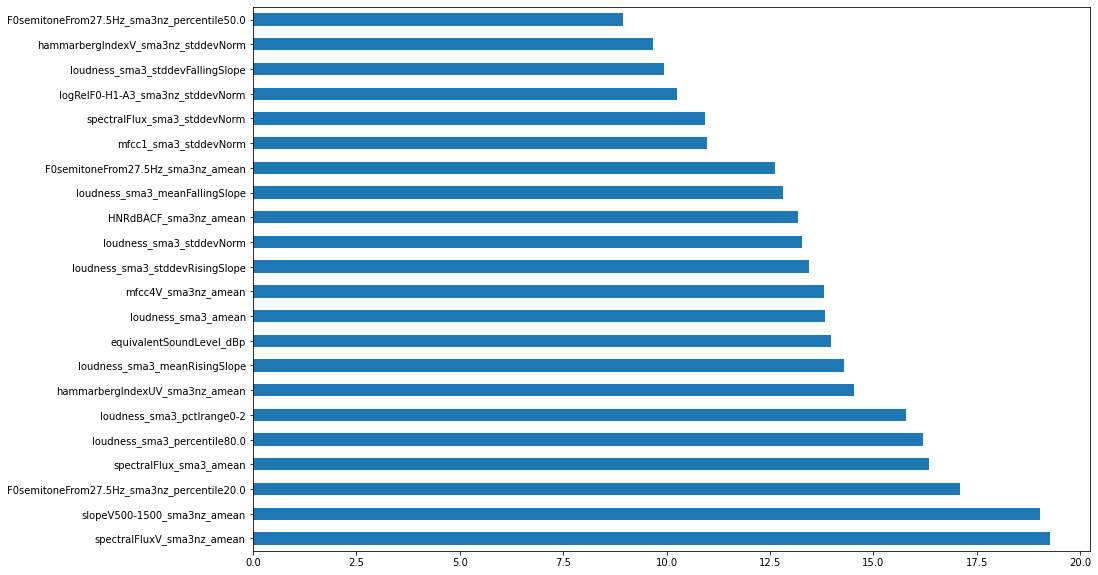

In [ ]:
select_feature = SelectKBest(f_classif, k=dim).fit(X_eGeMAPSv02_Functionals, y)

top_features=pd.Series(select_feature.scores_,index=X_eGeMAPSv02_Functionals.columns)
top_features=top_features.dropna()
plt.figure(figsize=(15, 10))
top_features.nlargest(dim).plot(kind='barh')

important_features=top_features.sort_values(ascending=False)[:5].index.tolist()
mfcc_cols = [col for col in X_eGeMAPSv02_Functionals.columns if 'mfcc' in col]
mfcc_and_loudness_cols = [col for col in X_eGeMAPSv02_Functionals.columns if ('mfcc' in col) or ('loudness' in col)]
mfcc_and_amplitude_cols = [col for col in X_eGeMAPSv02_Functionals.columns if ('mfcc' in col) or ('amplitude' in col)]
mfcc_and_bandwidth_cols = [col for col in X_eGeMAPSv02_Functionals.columns if ('mfcc' in col) or ('bandwidth' in col)]
mfcc_and_frequency_cols = [col for col in X_eGeMAPSv02_Functionals.columns if ('mfcc' in col) or ('frequency' in col)]
bandwidth_frequency_amplitude_cols = [col for col in X_eGeMAPSv02_Functionals.columns if ('bandwidth' in col) or ('frequency' in col) or ('amplitude' in col)]

In [ ]:
cross_validated_data={'model':[],
                      'result_all':[], 
                      'result_imp':[], 
                      'result_mfcc':[],
                      'result_mfcc_and_loudness':[],
                      'result_mfcc_and_amplitude':[],
                      'result_mfcc_and_bandwidth':[],
                      'result_mfcc_and_frequency':[],
                      'result_bandwidth_frequency_amplitude':[],
                     }
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .2, train_size = .8, random_state = SEED )

In [ ]:
# For all Features
classification(X_eGeMAPSv02_Functionals, unScaledData__eGeMAPSv02_Functionals, y, 'all', cross_validated_data)

# For importnat Features
classification(X_eGeMAPSv02_Functionals[important_features], unScaledData__eGeMAPSv02_Functionals[important_features], y, 'imp', cross_validated_data)

# For MFCC Features
classification(X_eGeMAPSv02_Functionals[mfcc_cols], unScaledData__eGeMAPSv02_Functionals[mfcc_cols], y, 'mfcc', cross_validated_data)

# For mfcc_and_loudness Features
classification(X_eGeMAPSv02_Functionals[mfcc_and_loudness_cols], unScaledData__eGeMAPSv02_Functionals[mfcc_and_loudness_cols], y, 'mfcc_and_loudness', cross_validated_data)

# For mfcc_and_amplitude Features
classification(X_eGeMAPSv02_Functionals[mfcc_and_amplitude_cols], unScaledData__eGeMAPSv02_Functionals[mfcc_and_amplitude_cols],  y, 'mfcc_and_amplitude', cross_validated_data)

# For mfcc_and_bandwidth Features
classification(X_eGeMAPSv02_Functionals[mfcc_and_bandwidth_cols], unScaledData__eGeMAPSv02_Functionals[mfcc_and_bandwidth_cols], y, 'mfcc_and_bandwidth', cross_validated_data)

# For mfcc_and_frequency Features
classification(X_eGeMAPSv02_Functionals[mfcc_and_frequency_cols],unScaledData__eGeMAPSv02_Functionals[mfcc_and_frequency_cols], y, 'mfcc_and_frequency', cross_validated_data)

# For bandwidth_frequency_amplitude Features
classification(X_eGeMAPSv02_Functionals[bandwidth_frequency_amplitude_cols], unScaledData__eGeMAPSv02_Functionals[bandwidth_frequency_amplitude_cols], y, 'bandwidth_frequency_amplitude', cross_validated_data)

-----
For all features
- - - -
Applied Model:Random Forest
Best parameters {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 200}
Mean cross-validated accuracy score of the best_estimator: 0.53
-----
-----
For all features
- - - -
Applied Model:Decision Tree
Best parameters {'max_depth': 3}
Mean cross-validated accuracy score of the best_estimator: 0.55
-----
-----
For all features
- - - -
Applied Model:SVM
Best parameters {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Mean cross-validated accuracy score of the best_estimator: 0.57
-----
-----
For all features
- - - -
Applied Model:Logistic Regression
Best parameters {'C': 0.001, 'penalty': 'l2'}
Mean cross-validated accuracy score of the best_estimator: 0.54
-----
-----
For all features
- - - -
Applied Model:KNN
Best parameters {'n_neighbors': 5, 'weights': 'uniform'}
Mean cross-validated accuracy score of the best_estimator: 0.54
-----
-----
For imp features
- - - -
Applied Model:Random Forest
Best parame

#### Accuracy

In [ ]:
performance_df_all=pd.DataFrame(cross_validated_data['result_all'][:5],columns=['Best Parameters for All','Accuracy for All'],
                            index=cross_validated_data['model_all'][:5])
performance_df_all.style.set_properties(subset=['Best Parameters for All'], **{'width': '300px'})

,Best Parameters for All,Accuracy for All
Random Forest,"{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 200}",52.770000
Decision Tree,{'max_depth': 3},55.080000
SVM,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}",56.770000
Logistic Regression,"{'C': 0.001, 'penalty': 'l2'}",54.310000
KNN,"{'n_neighbors': 5, 'weights': 'uniform'}",54.000000


In [ ]:
performance_df_mfcc=pd.DataFrame(cross_validated_data['result_mfcc'][:5],columns=['Best Parameters for MFCC','Accuracy for MFCC'],
                            index=cross_validated_data['model_mfcc'][:5])
performance_df_mfcc.style.set_properties(subset=['Best Parameters for MFCC'], **{'width': '300px'})

,Best Parameters for MFCC,Accuracy for MFCC
Random Forest,"{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200}",52.310000
Decision Tree,{'max_depth': 11},54.770000
SVM,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}",55.850000
Logistic Regression,"{'C': 0.1, 'penalty': 'l2'}",54.620000
KNN,"{'n_neighbors': 20, 'weights': 'uniform'}",55.080000


In [ ]:
performance_df_mfcc_and_loudness=pd.DataFrame(cross_validated_data['result_mfcc_and_loudness'][:5],columns=['Best Parameters for mfcc and loudness features','Accuracy mfcc and loudness features'],
                            index=cross_validated_data['model_mfcc_and_loudness'][:5])
performance_df_mfcc_and_loudness.style.set_properties(subset=['Best Parameters for mfcc and loudness features'], **{'width': '300px'})

,Best Parameters for mfcc and loudness features,Accuracy mfcc and loudness features
Random Forest,"{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 500}",54.920000
Decision Tree,{'max_depth': 5},54.620000
SVM,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}",58.000000
Logistic Regression,"{'C': 0.001, 'penalty': 'l2'}",56.460000
KNN,"{'n_neighbors': 5, 'weights': 'uniform'}",54.620000


In [ ]:
performance_df_imp=pd.DataFrame(cross_validated_data['result_imp'][:5],columns=['Best Parameters for Important features','Accuracy for Important features'],
                            index=cross_validated_data['model_imp'][:5])
performance_df_imp.style.set_properties(subset=['Best Parameters for Important features'], **{'width': '300px'})

,Best Parameters for Important features,Accuracy for Important features
Random Forest,"{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 200}",59.850000
Decision Tree,{'max_depth': 5},55.690000
SVM,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}",56.920000
Logistic Regression,"{'C': 0.01, 'penalty': 'l2'}",56.770000
KNN,"{'n_neighbors': 25, 'weights': 'uniform'}",52.920000


In [ ]:
performance_df_mfcc_and_amplitude=pd.DataFrame(cross_validated_data['result_mfcc_and_amplitude'][:5],columns=['Best Parameters for mfcc and amplitude features','Accuracy for mfcc and amplitude features'],
                            index=cross_validated_data['model_mfcc_and_amplitude'][:5])
performance_df_mfcc_and_amplitude.style.set_properties(subset=['Best Parameters for mfcc and amplitude features'], **{'width': '300px'})

,Best Parameters for mfcc and amplitude features,Accuracy for mfcc and amplitude features
Random Forest,"{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 200}",52.150000
Decision Tree,{'max_depth': 7},52.920000
SVM,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}",56.000000
Logistic Regression,"{'C': 0.1, 'penalty': 'l2'}",54.000000
KNN,"{'n_neighbors': 5, 'weights': 'uniform'}",57.380000


In [ ]:
performance_df_mfcc_and_bandwidth=pd.DataFrame(cross_validated_data['result_mfcc_and_bandwidth'][:5],columns=['Best Parameters for mfcc and bandwidth features','Accuracy for mfcc and bandwidth features'],
                            index=cross_validated_data['model_mfcc_and_bandwidth'][:5])
performance_df_mfcc_and_bandwidth.style.set_properties(subset=['Best Parameters for mfcc and bandwidth features'], **{'width': '300px'})

,Best Parameters for mfcc and bandwidth features,Accuracy for mfcc and bandwidth features
Random Forest,"{'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 200}",52.460000
Decision Tree,{'max_depth': 7},50.460000
SVM,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}",55.230000
Logistic Regression,"{'C': 0.001, 'penalty': 'l1'}",52.150000
KNN,"{'n_neighbors': 5, 'weights': 'distance'}",55.540000


In [ ]:
performance_df_bandwidth_frequency_amplitude=pd.DataFrame(cross_validated_data['result_bandwidth_frequency_amplitude'][:5],columns=['Best Parameters for bandwidth,frequency and amplitude features','Accuracy for bandwidth,frequency and amplitude features'],
                            index=cross_validated_data['model_bandwidth_frequency_amplitude'][:5])
performance_df_bandwidth_frequency_amplitude.style.set_properties(subset=['Best Parameters for bandwidth,frequency and amplitude features'], **{'width': '400px'})

,"Best Parameters for bandwidth,frequency and amplitude features","Accuracy for bandwidth,frequency and amplitude features"
Random Forest,"{'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 200}",52.000000
Decision Tree,{'max_depth': 9},52.460000
SVM,"{'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}",54.920000
Logistic Regression,"{'C': 0.001, 'penalty': 'l1'}",52.150000
KNN,"{'n_neighbors': 10, 'weights': 'uniform'}",53.380000


In [ ]:
performance_df_mfcc_and_frequency=pd.DataFrame(cross_validated_data['result_mfcc_and_frequency'][:5],columns=['Best Parameters for mfcc and frequency features','Accuracy for mfcc and frequency features'],
                            index=cross_validated_data['model_mfcc_and_frequency'][:5])
performance_df_mfcc_and_frequency.style.set_properties(subset=['Best Parameters for mfcc and frequency features'], **{'width': '300px'})

,Best Parameters for mfcc and frequency features,Accuracy for mfcc and frequency features
Random Forest,"{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 500}",51.690000
Decision Tree,{'max_depth': 13},55.690000
SVM,"{'C': 1.0, 'gamma': 'scale', 'kernel': 'linear'}",56.770000
Logistic Regression,"{'C': 1.0, 'penalty': 'l2'}",57.230000
KNN,"{'n_neighbors': 5, 'weights': 'uniform'}",56.150000


In [ ]:
performance_df = pd.concat([performance_df_all, performance_df_mfcc, performance_df_imp, performance_df_mfcc_and_loudness, performance_df_mfcc_and_amplitude, performance_df_mfcc_and_bandwidth, performance_df_mfcc_and_frequency, performance_df_bandwidth_frequency_amplitude], axis=1)
# performance_df.to_csv(f'{base_dir}/Audio_Accuracy_For_eGeMAPSv02_Functionals_without_correlation.csv')

#### Accuracy of eGeMAPSv02_Functionals Features (with correlations)

In [ ]:
corr_features = correlation(X_eGeMAPSv02_Functionals, 0.9)
print(corr_features,len(corr_features))
X_eGeMAPSv02_Functionals=X_eGeMAPSv02_Functionals.drop(corr_features,axis=1)
unScaledData__eGeMAPSv02_Functionals=unScaledData__eGeMAPSv02_Functionals.drop(corr_features,axis=1)
print(len(X_eGeMAPSv02_Functionals.columns))
print(len(unScaledData__eGeMAPSv02_Functionals.columns))

{'F3amplitudeLogRelF0_sma3nz_amean', 'loudness_sma3_percentile50.0', 'equivalentSoundLevel_dBp', 'F3frequency_sma3nz_amean', 'loudness_sma3_meanRisingSlope', 'spectralFlux_sma3_amean', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'loudness_sma3_stddevFallingSlope', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0', 'spectralFlux_sma3_stddevNorm', 'F2amplitudeLogRelF0_sma3nz_stddevNorm', 'mfcc4V_sma3nz_amean', 'F2frequency_sma3nz_amean', 'StddevVoicedSegmentLengthSec', 'loudness_sma3_percentile80.0', 'spectralFluxV_sma3nz_amean', 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope', 'mfcc2V_sma3nz_amean', 'loudness_sma3_stddevRisingSlope', 'StddevUnvoicedSegmentLength', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'loudness_sma3_pctlrange0-2', 'F3amplitudeLogRelF0_sma3nz_stddevNorm', 'F2amplitudeLogRelF0_sma3nz_amean', 'loudness_sma3_meanFallingSlope'} 25
63
63


The number of dimensions required to preserve 90% of variance is 22


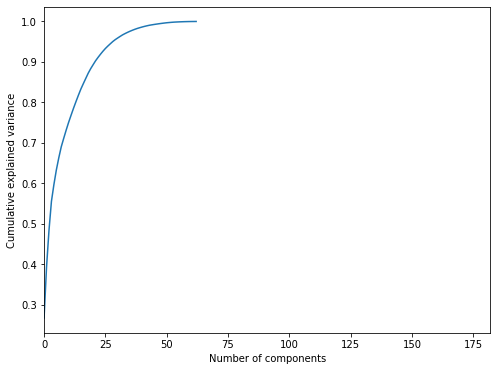

In [ ]:
pca= PCA()
pca.fit(X_eGeMAPSv02_Functionals)
cumsum = np.cumsum(pca.explained_variance_ratio_)
dim = np.argmax(cumsum >= 0.90) + 1
print('The number of dimensions required to preserve 90% of variance is',dim)
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,182,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

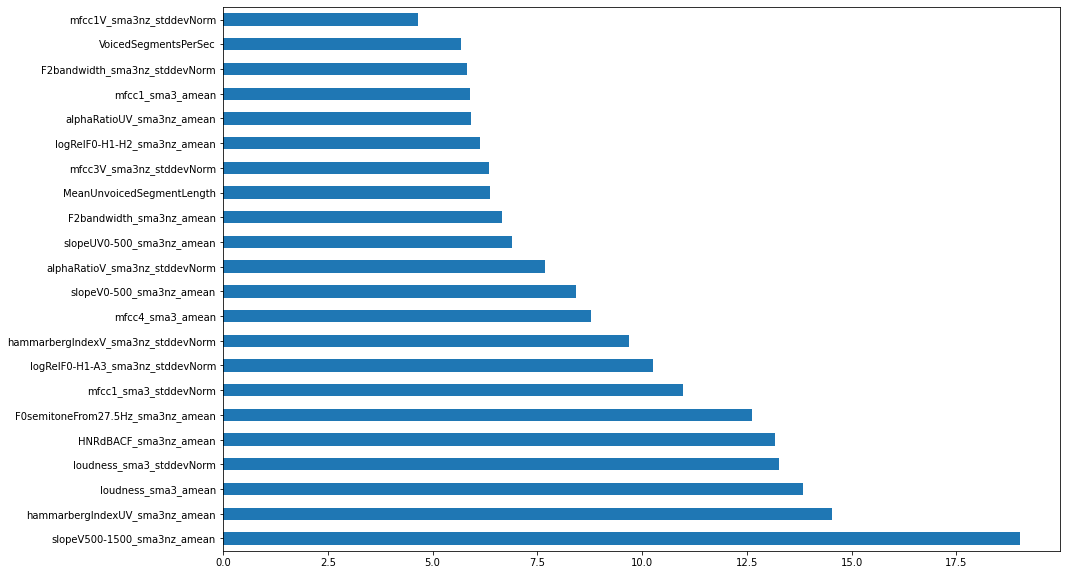

In [ ]:
select_feature = SelectKBest(f_classif, k=dim).fit(X_eGeMAPSv02_Functionals, y)

top_features=pd.Series(select_feature.scores_,index=X_eGeMAPSv02_Functionals.columns)
top_features=top_features.dropna()
plt.figure(figsize=(15, 10))
top_features.nlargest(dim).plot(kind='barh')

important_features=top_features.sort_values(ascending=False)[:5].index.tolist()
mfcc_cols = [col for col in X_eGeMAPSv02_Functionals.columns if 'mfcc' in col]
mfcc_and_loudness_cols = [col for col in X_eGeMAPSv02_Functionals.columns if ('mfcc' in col) or ('loudness' in col)]
mfcc_and_amplitude_cols = [col for col in X_eGeMAPSv02_Functionals.columns if ('mfcc' in col) or ('amplitude' in col)]
mfcc_and_bandwidth_cols = [col for col in X_eGeMAPSv02_Functionals.columns if ('mfcc' in col) or ('bandwidth' in col)]
mfcc_and_frequency_cols = [col for col in X_eGeMAPSv02_Functionals.columns if ('mfcc' in col) or ('frequency' in col)]
bandwidth_frequency_amplitude_cols = [col for col in X_eGeMAPSv02_Functionals.columns if ('bandwidth' in col) or ('frequency' in col) or ('amplitude' in col)]

In [ ]:
cross_validated_data={'model':[],
                      'result_all':[], 
                      'result_imp':[], 
                      'result_mfcc':[],
                      'result_mfcc_and_loudness':[],
                      'result_mfcc_and_amplitude':[],
                      'result_mfcc_and_bandwidth':[],
                      'result_mfcc_and_frequency':[],
                      'result_bandwidth_frequency_amplitude':[],
                     }
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .2, train_size = .8, random_state = SEED )

In [ ]:
# For all Features
classification(X_eGeMAPSv02_Functionals, unScaledData__eGeMAPSv02_Functionals, y, 'all', cross_validated_data)

# For importnat Features
classification(X_eGeMAPSv02_Functionals[important_features], unScaledData__eGeMAPSv02_Functionals[important_features], y, 'imp', cross_validated_data)

# For MFCC Features
classification(X_eGeMAPSv02_Functionals[mfcc_cols], unScaledData__eGeMAPSv02_Functionals[mfcc_cols], y, 'mfcc', cross_validated_data)

# For mfcc_and_loudness Features
classification(X_eGeMAPSv02_Functionals[mfcc_and_loudness_cols], unScaledData__eGeMAPSv02_Functionals[mfcc_and_loudness_cols], y, 'mfcc_and_loudness', cross_validated_data)

# For mfcc_and_amplitude Features
classification(X_eGeMAPSv02_Functionals[mfcc_and_amplitude_cols], unScaledData__eGeMAPSv02_Functionals[mfcc_and_amplitude_cols],  y, 'mfcc_and_amplitude', cross_validated_data)

# For mfcc_and_bandwidth Features
classification(X_eGeMAPSv02_Functionals[mfcc_and_bandwidth_cols], unScaledData__eGeMAPSv02_Functionals[mfcc_and_bandwidth_cols], y, 'mfcc_and_bandwidth', cross_validated_data)

# For mfcc_and_frequency Features
classification(X_eGeMAPSv02_Functionals[mfcc_and_frequency_cols],unScaledData__eGeMAPSv02_Functionals[mfcc_and_frequency_cols], y, 'mfcc_and_frequency', cross_validated_data)

# For bandwidth_frequency_amplitude Features
classification(X_eGeMAPSv02_Functionals[bandwidth_frequency_amplitude_cols], unScaledData__eGeMAPSv02_Functionals[bandwidth_frequency_amplitude_cols], y, 'bandwidth_frequency_amplitude', cross_validated_data)

-----
For all features
- - - -
Applied Model:Random Forest
Best parameters {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}
Mean cross-validated accuracy score of the best_estimator: 0.54
-----
-----
For all features
- - - -
Applied Model:Decision Tree
Best parameters {'max_depth': 7}
Mean cross-validated accuracy score of the best_estimator: 0.55
-----
-----
For all features
- - - -
Applied Model:SVM
Best parameters {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean cross-validated accuracy score of the best_estimator: 0.57
-----
-----
For all features
- - - -
Applied Model:Logistic Regression
Best parameters {'C': 0.001, 'penalty': 'l2'}
Mean cross-validated accuracy score of the best_estimator: 0.54
-----
-----
For all features
- - - -
Applied Model:KNN
Best parameters {'n_neighbors': 7, 'weights': 'distance'}
Mean cross-validated accuracy score of the best_estimator: 0.54
-----
-----
For imp features
- - - -
Applied Model:Random Forest
Best para

#### Accuracy

In [ ]:
performance_df_all=pd.DataFrame(cross_validated_data['result_all'][:5],columns=['Best Parameters for All','Accuracy for All'],
                            index=cross_validated_data['model'][:5])
performance_df_all.style.set_properties(subset=['Best Parameters for All'], **{'width': '300px'})

,Best Parameters for All,Accuracy for All
Random Forest,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}",53.540000
Decision Tree,{'max_depth': 7},55.230000
SVM,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}",57.080000
Logistic Regression,"{'C': 0.001, 'penalty': 'l2'}",54.310000
KNN,"{'n_neighbors': 7, 'weights': 'distance'}",53.540000


In [ ]:
performance_df_mfcc=pd.DataFrame(cross_validated_data['result_mfcc'][:5],columns=['Best Parameters for MFCC','Accuracy for MFCC'],
                            index=cross_validated_data['model'][:5])
performance_df_mfcc.style.set_properties(subset=['Best Parameters for MFCC'], **{'width': '300px'})

,Best Parameters for MFCC,Accuracy for MFCC
Random Forest,"{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 500}",51.380000
Decision Tree,{'max_depth': 11},56.460000
SVM,"{'C': 1.0, 'gamma': 'scale', 'kernel': 'linear'}",56.460000
Logistic Regression,"{'C': 0.1, 'penalty': 'l2'}",54.770000
KNN,"{'n_neighbors': 5, 'weights': 'distance'}",55.850000


In [ ]:
performance_df_mfcc_and_loudness=pd.DataFrame(cross_validated_data['result_mfcc_and_loudness'][:5],columns=['Best Parameters for mfcc and loudness features','Accuracy mfcc and loudness features'],
                            index=cross_validated_data['model'][:5])
performance_df_mfcc_and_loudness.style.set_properties(subset=['Best Parameters for mfcc and loudness features'], **{'width': '300px'})

,Best Parameters for mfcc and loudness features,Accuracy mfcc and loudness features
Random Forest,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}",54.620000
Decision Tree,{'max_depth': 13},54.310000
SVM,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}",56.150000
Logistic Regression,"{'C': 0.01, 'penalty': 'l2'}",54.770000
KNN,"{'n_neighbors': 8, 'weights': 'distance'}",56.460000


In [ ]:
performance_df_imp=pd.DataFrame(cross_validated_data['result_imp'][:5],columns=['Best Parameters for Important features','Accuracy for Important features'],
                            index=cross_validated_data['model'][:5])
performance_df_imp.style.set_properties(subset=['Best Parameters for Important features'], **{'width': '300px'})

,Best Parameters for Important features,Accuracy for Important features
Random Forest,"{'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 200}",58.460000
Decision Tree,{'max_depth': 3},59.080000
SVM,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}",57.540000
Logistic Regression,"{'C': 0.001, 'penalty': 'l2'}",59.230000
KNN,"{'n_neighbors': 10, 'weights': 'uniform'}",58.770000


In [ ]:
performance_df_mfcc_and_amplitude=pd.DataFrame(cross_validated_data['result_mfcc_and_amplitude'][:5],columns=['Best Parameters for mfcc and amplitude features','Accuracy for mfcc and amplitude features'],
                            index=cross_validated_data['model'][:5])
performance_df_mfcc_and_amplitude.style.set_properties(subset=['Best Parameters for mfcc and amplitude features'], **{'width': '300px'})

,Best Parameters for mfcc and amplitude features,Accuracy for mfcc and amplitude features
Random Forest,"{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 500}",52.460000
Decision Tree,{'max_depth': 7},56.460000
SVM,"{'C': 1.0, 'gamma': 'scale', 'kernel': 'linear'}",55.380000
Logistic Regression,"{'C': 0.1, 'penalty': 'l2'}",54.150000
KNN,"{'n_neighbors': 5, 'weights': 'distance'}",58.460000


In [ ]:
performance_df_mfcc_and_bandwidth=pd.DataFrame(cross_validated_data['result_mfcc_and_bandwidth'][:5],columns=['Best Parameters for mfcc and bandwidth features','Accuracy for mfcc and bandwidth features'],
                            index=cross_validated_data['model'][:5])
performance_df_mfcc_and_bandwidth.style.set_properties(subset=['Best Parameters for mfcc and bandwidth features'], **{'width': '300px'})

,Best Parameters for mfcc and bandwidth features,Accuracy for mfcc and bandwidth features
Random Forest,"{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}",52.460000
Decision Tree,{'max_depth': 9},53.230000
SVM,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}",54.920000
Logistic Regression,"{'C': 0.001, 'penalty': 'l1'}",52.150000
KNN,"{'n_neighbors': 10, 'weights': 'distance'}",54.460000


In [ ]:
performance_df_bandwidth_frequency_amplitude=pd.DataFrame(cross_validated_data['result_bandwidth_frequency_amplitude'][:5],columns=['Best Parameters for bandwidth,frequency and amplitude features','Accuracy for bandwidth,frequency and amplitude features'],
                            index=cross_validated_data['model'][:5])
performance_df_bandwidth_frequency_amplitude.style.set_properties(subset=['Best Parameters for bandwidth,frequency and amplitude features'], **{'width': '400px'})

,"Best Parameters for bandwidth,frequency and amplitude features","Accuracy for bandwidth,frequency and amplitude features"
Random Forest,"{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}",52.620000
Decision Tree,{'max_depth': 11},53.690000
SVM,"{'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}",53.540000
Logistic Regression,"{'C': 0.001, 'penalty': 'l1'}",52.150000
KNN,"{'n_neighbors': 5, 'weights': 'uniform'}",53.690000


In [ ]:
performance_df_mfcc_and_frequency=pd.DataFrame(cross_validated_data['result_mfcc_and_frequency'][:5],columns=['Best Parameters for mfcc and frequency features','Accuracy for mfcc and frequency features'],
                            index=cross_validated_data['model'][:5])
performance_df_mfcc_and_frequency.style.set_properties(subset=['Best Parameters for mfcc and frequency features'], **{'width': '300px'})

,Best Parameters for mfcc and frequency features,Accuracy for mfcc and frequency features
Random Forest,"{'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200}",51.380000
Decision Tree,{'max_depth': 9},54.620000
SVM,"{'C': 1.0, 'gamma': 'scale', 'kernel': 'linear'}",56.460000
Logistic Regression,"{'C': 1.0, 'penalty': 'l1'}",56.310000
KNN,"{'n_neighbors': 10, 'weights': 'distance'}",55.080000


In [ ]:
performance_df = pd.concat([performance_df_all, performance_df_mfcc, performance_df_imp, performance_df_mfcc_and_loudness, performance_df_mfcc_and_amplitude, performance_df_mfcc_and_bandwidth, performance_df_mfcc_and_frequency, performance_df_bandwidth_frequency_amplitude], axis=1)
# performance_df.to_csv(f'{base_dir}/Audio_Accuracy_For_eGeMAPSv02_Functionals_with_correlation.csv')

### eGeMAPSv02_LowLevelDescriptors

#### eGeMAPSv02_LowLevelDescriptors Features Scalling

In [ ]:
columns = [column for column in df.columns if ('eGeMAPSv02_LowLevelDescriptors' in column) or ('label' in column)]
eGeMAPSv02_LowLevelDescriptors = df[columns]
columns = [column.replace('eGeMAPSv02_LowLevelDescriptors__', '') for column in eGeMAPSv02_LowLevelDescriptors.columns]
eGeMAPSv02_LowLevelDescriptors.columns = columns
eGeMAPSv02_LowLevelDescriptors.head()

,Loudness_sma3_max,alphaRatio_sma3_max,hammarbergIndex_sma3_max,slope0-500_sma3_max,slope500-1500_sma3_max,spectralFlux_sma3_max,mfcc1_sma3_max,mfcc2_sma3_max,mfcc3_sma3_max,mfcc4_sma3_max,F0semitoneFrom27.5Hz_sma3nz_max,jitterLocal_sma3nz_max,shimmerLocaldB_sma3nz_max,HNRdBACF_sma3nz_max,logRelF0-H1-H2_sma3nz_max,logRelF0-H1-A3_sma3nz_max,F1frequency_sma3nz_max,F1bandwidth_sma3nz_max,F1amplitudeLogRelF0_sma3nz_max,F2frequency_sma3nz_max,F2bandwidth_sma3nz_max,F2amplitudeLogRelF0_sma3nz_max,F3frequency_sma3nz_max,F3bandwidth_sma3nz_max,F3amplitudeLogRelF0_sma3nz_max,Loudness_sma3_min,alphaRatio_sma3_min,hammarbergIndex_sma3_min,slope0-500_sma3_min,slope500-1500_sma3_min,spectralFlux_sma3_min,mfcc1_sma3_min,mfcc2_sma3_min,mfcc3_sma3_min,mfcc4_sma3_min,F0semitoneFrom27.5Hz_sma3nz_min,jitterLocal_sma3nz_min,shimmerLocaldB_sma3nz_min,HNRdBACF_sma3nz_min,logRelF0-H1-H2_sma3nz_min,...,jitterLocal_sma3nz_skew,shimmerLocaldB_sma3nz_skew,HNRdBACF_sma3nz_skew,logRelF0-H1-H2_sma3nz_skew,logRelF0-H1-A3_sma3nz_skew,F1frequency_sma3nz_skew,F1bandwidth_sma3nz_skew,F1amplitudeLogRelF0_sma3nz_skew,F2frequency_sma3nz_skew,F2bandwidth_sma3nz_skew,F2amplitudeLogRelF0_sma3nz_skew,F3frequency_sma3nz_skew,F3bandwidth_sma3nz_skew,F3amplitudeLogRelF0_sma3nz_skew,Loudness_sma3_kurt,alphaRatio_sma3_kurt,hammarbergIndex_sma3_kurt,slope0-500_sma3_kurt,slope500-1500_sma3_kurt,spectralFlux_sma3_kurt,mfcc1_sma3_kurt,mfcc2_sma3_kurt,mfcc3_sma3_kurt,mfcc4_sma3_kurt,F0semitoneFrom27.5Hz_sma3nz_kurt,jitterLocal_sma3nz_kurt,shimmerLocaldB_sma3nz_kurt,HNRdBACF_sma3nz_kurt,logRelF0-H1-H2_sma3nz_kurt,logRelF0-H1-A3_sma3nz_kurt,F1frequency_sma3nz_kurt,F1bandwidth_sma3nz_kurt,F1amplitudeLogRelF0_sma3nz_kurt,F2frequency_sma3nz_kurt,F2bandwidth_sma3nz_kurt,F2amplitudeLogRelF0_sma3nz_kurt,F3frequency_sma3nz_kurt,F3bandwidth_sma3nz_kurt,F3amplitudeLogRelF0_sma3nz_kurt,label
0,0.562542,1.891820,36.562016,0.112000,0.076364,0.373106,46.077694,30.952919,35.550915,15.245040,27.431372,0.123310,3.256463,6.986582,24.403833,42.980885,1203.4541,2346.7744,17.261082,2335.4543,2675.9119,2.192063,3512.7383,3817.4460,-4.046801,0.001034,-25.043358,-3.900811e-01,-0.042679,-0.026816,0.0,-0.167717,-14.792930,0.000000,-17.293330,0.0,0.0,0.0,-0.183663,-10.457564,...,2.508423,0.952011,0.832391,0.915577,0.209150,0.406225,-1.382496,0.043625,-0.984419,0.481367,0.041267,-3.488585,3.109374,0.037522,0.156468,2.937462,6.310820,4.267917,32.159109,1.332823,6.719213,0.756414,0.555784,-0.134547,-1.968087,8.765405,-0.058930,-0.327511,0.255450,-1.756748,-0.538866,10.791142,-1.874492,7.501134,6.119978,-1.875751,28.127408,23.914307,-1.880230,1
1,0.701472,2.018135,32.366090,0.112000,0.076364,0.269050,44.489887,26.176977,34.237820,18.371222,27.186860,0.231977,3.427923,5.800100,108.194500,37.554700,1329.7069,2933.2030,6.975212,2513.7532,2322.7630,2.663934,3684.3477,2337.5608,-5.609837,0.001034,-22.449997,-2.588597e-07,-0.023698,-0.025513,0.0,0.000000,-27.149162,-2.128746,-20.875000,0.0,0.0,0.0,0.000000,-11.064644,...,3.568450,1.122903,1.111440,4.812714,0.470638,0.051052,-0.897283,0.255289,-1.243981,0.084785,0.257486,-3.084400,0.258255,0.249567,0.900915,1.685100,5.954287,7.616150,28.403553,0.178859,9.288540,1.183819,0.787173,1.283158,-1.893359,22.280070,0.149235,0.273954,54.752676,-1.617828,-0.696415,13.873100,-1.790913,6.486719,6.036619,-1.779561,21.085616,5.645184,-1.789482,0
2,0.745084,1.663851,56.062090,0.120268,0.076364,1.235239,43.140410,31.316446,46.617794,19.282860,37.274560,0.179755,3.810700,14.599258,26.260717,46.598175,1186.0004,2597.2480,6.455240,2322.4128,2786.1934,-0.902254,3479.1638,2023.0814,-9.606182,0.001034,-39.938934,-2.707062e-04,-0.048265,-0.029570,0.0,0.000000,-22.836730,-0.077493,-26.666206,0.0,0.0,0.0,0.000000,-23.397795,...,3.553040,1.023396,1.981022,-0.325977,0.058463,-0.046518,-1.108953,-0.311050,-1.318270,0.666064,-0.309071,-3.144306,0.018028,-0.310634,-0.217612,2.488690,2.221871,5.974602,46.558624,37.784992,6.185507,0.758336,1.679174,0.329641,-1.557597,17.929100,0.340571,3.035398,0.

In [ ]:
unScaledData__eGeMAPSv02_LowLevelDescriptors = eGeMAPSv02_LowLevelDescriptors.drop('label', axis=1)

X_eGeMAPSv02_LowLevelDescriptors = eGeMAPSv02_LowLevelDescriptors.drop('label', axis=1)
y = df.iloc[:, -1]

In [ ]:
scaler = StandardScaler()
scaler.fit(X_eGeMAPSv02_LowLevelDescriptors)
scaled_features_eGeMAPSv02_Functionals = scaler.transform(X_eGeMAPSv02_LowLevelDescriptors)
scaled_features_eGeMAPSv02_Functionals

X_eGeMAPSv02_LowLevelDescriptors = pd.DataFrame(scaled_features_eGeMAPSv02_Functionals, columns=X_eGeMAPSv02_LowLevelDescriptors.columns)
X_eGeMAPSv02_LowLevelDescriptors.head()

,Loudness_sma3_max,alphaRatio_sma3_max,hammarbergIndex_sma3_max,slope0-500_sma3_max,slope500-1500_sma3_max,spectralFlux_sma3_max,mfcc1_sma3_max,mfcc2_sma3_max,mfcc3_sma3_max,mfcc4_sma3_max,F0semitoneFrom27.5Hz_sma3nz_max,jitterLocal_sma3nz_max,shimmerLocaldB_sma3nz_max,HNRdBACF_sma3nz_max,logRelF0-H1-H2_sma3nz_max,logRelF0-H1-A3_sma3nz_max,F1frequency_sma3nz_max,F1bandwidth_sma3nz_max,F1amplitudeLogRelF0_sma3nz_max,F2frequency_sma3nz_max,F2bandwidth_sma3nz_max,F2amplitudeLogRelF0_sma3nz_max,F3frequency_sma3nz_max,F3bandwidth_sma3nz_max,F3amplitudeLogRelF0_sma3nz_max,Loudness_sma3_min,alphaRatio_sma3_min,hammarbergIndex_sma3_min,slope0-500_sma3_min,slope500-1500_sma3_min,spectralFlux_sma3_min,mfcc1_sma3_min,mfcc2_sma3_min,mfcc3_sma3_min,mfcc4_sma3_min,F0semitoneFrom27.5Hz_sma3nz_min,jitterLocal_sma3nz_min,shimmerLocaldB_sma3nz_min,HNRdBACF_sma3nz_min,logRelF0-H1-H2_sma3nz_min,...,F0semitoneFrom27.5Hz_sma3nz_skew,jitterLocal_sma3nz_skew,shimmerLocaldB_sma3nz_skew,HNRdBACF_sma3nz_skew,logRelF0-H1-H2_sma3nz_skew,logRelF0-H1-A3_sma3nz_skew,F1frequency_sma3nz_skew,F1bandwidth_sma3nz_skew,F1amplitudeLogRelF0_sma3nz_skew,F2frequency_sma3nz_skew,F2bandwidth_sma3nz_skew,F2amplitudeLogRelF0_sma3nz_skew,F3frequency_sma3nz_skew,F3bandwidth_sma3nz_skew,F3amplitudeLogRelF0_sma3nz_skew,Loudness_sma3_kurt,alphaRatio_sma3_kurt,hammarbergIndex_sma3_kurt,slope0-500_sma3_kurt,slope500-1500_sma3_kurt,spectralFlux_sma3_kurt,mfcc1_sma3_kurt,mfcc2_sma3_kurt,mfcc3_sma3_kurt,mfcc4_sma3_kurt,F0semitoneFrom27.5Hz_sma3nz_kurt,jitterLocal_sma3nz_kurt,shimmerLocaldB_sma3nz_kurt,HNRdBACF_sma3nz_kurt,logRelF0-H1-H2_sma3nz_kurt,logRelF0-H1-A3_sma3nz_kurt,F1frequency_sma3nz_kurt,F1bandwidth_sma3nz_kurt,F1amplitudeLogRelF0_sma3nz_kurt,F2frequency_sma3nz_kurt,F2bandwidth_sma3nz_kurt,F2amplitudeLogRelF0_sma3nz_kurt,F3frequency_sma3nz_kurt,F3bandwidth_sma3nz_kurt,F3amplitudeLogRelF0_sma3nz_kurt
0,-0.345821,-0.077478,-0.559145,-0.129177,0.329526,-0.173741,0.595496,-0.208984,-0.378242,-1.292531,-0.696905,-0.621474,-1.031532,-0.394106,-0.426371,0.039677,-0.601813,-0.777164,0.858850,-0.951800,-0.603937,0.175508,-0.864448,1.274376,0.364486,-0.327703,0.241662,0.240646,-0.071709,0.669380,-0.297876,0.355367,0.345060,1.287404,0.715633,0.0,0.0,0.0,0.498605,0.392233,...,0.193817,-0.472217,-0.219624,0.236068,-0.032272,0.140085,1.672019,-1.290448,0.263661,-0.134839,-1.178890,0.265422,-0.978951,1.552643,0.264509,-0.253162,0.375638,1.433188,-0.092526,1.317361,-0.105710,1.004909,-0.432401,-0.480447,-0.916353,-0.512029,-0.438975,-0.434684,-0.147231,-0.490035,-0.293150,-0.448987,0.082881,-0.478435,0.537235,-0.368030,-0.478002,0.783699,1.950660,-0.481390
1,-0.103448,-0.052984,-1.254903,-0.129177,0.329526,-0.321859,0.220903,-0.713813,-0.493861,-0.836801,-0.725743,0.038859,-0.813495,-0.854237,1.895261,-0.681769,0.702677,0.346948,-0.450849,0.560758,-1.202515,0.226140,0.010370,-1.166298,0.209996,-0.327703,0.676453,0.331927,1.045117,0.762573,-0.297876,0.379278,-0.963651,1.083041,0.479921,0.0,0.0,0.0,0.620897,0.372139,...,0.444950,-0.099018,0.042832,0.547148,1.629070,0.418690,0.738193,-0.912276,0.501030,-0.518950,-1.626775,0.507006,-0.670843,-2.198033,0.501570,-0.052277,-0.068725,1.303186,0.815475,0.986258,-0.180270,1.725071,-0.154056,-0.279449,0.121745,-0.469749,-0.174286,-0.369854,0.108524,1.328536,-0.264713,-0.739123,0.516182,-0.431704,0.287474,-0.377853,-0.424994,0.094597,-0.486966,-0.431115
2,-0.027363,-0.121685,2.674309,1.887948,0.329526,1.053467,-0.097464,-0.170559,0.596211,-0.703904,0.464048,-0.278475,-0.326737,2.558176,-0.374921,0.520618,-0.782151,-0.297036,-0.517057,-1.062434,-0.417013,-0.156514,-1.035601,-1.684948,-0.185002,-0.327703,-2.255661,0.331864,-0.400382,0.472353,-0.297876,0.379278,-0.506900,1.279965,0.098798,0.0,0.0,0.0,0.620897,-0.036093,...,0.063934,-0.104443,-0.109990,1.516546,-0.561545,-0.020467,0.481663,-1.077250,-0.134086,-0.628885,-0.970300,-0.126014,-0.716508,-2.514054,-0.124721,-0.354106,0.216405,-0.057757,0.370307,2.586871,2.249543,0.855315,-0.431149,0.495398,-

#### Accuracy of eGeMAPSv02_LowLevelDescriptors Features

In [ ]:
corr_features = correlation(X_eGeMAPSv02_LowLevelDescriptors, 0.9)
print(corr_features,len(corr_features))
X_eGeMAPSv02_LowLevelDescriptors=X_eGeMAPSv02_LowLevelDescriptors.drop(corr_features,axis=1)
unScaledData__eGeMAPSv02_LowLevelDescriptors=unScaledData__eGeMAPSv02_LowLevelDescriptors.drop(corr_features,axis=1)
print(len(X_eGeMAPSv02_LowLevelDescriptors.columns))
print(len(unScaledData__eGeMAPSv02_LowLevelDescriptors.columns))

{'HNRdBACF_sma3nz_var', 'hammarbergIndex_sma3_std', 'mfcc2_sma3_var', 'F2frequency_sma3nz_median', 'alphaRatio_sma3_median', 'F3frequency_sma3nz_per50', 'jitterLocal_sma3nz_var', 'Loudness_sma3_median', 'mfcc4_sma3_std', 'alphaRatio_sma3_per75', 'slope0-500_sma3_median', 'F2bandwidth_sma3nz_median', 'hammarbergIndex_sma3_per25', 'F3frequency_sma3nz_var', 'F1bandwidth_sma3nz_per50', 'F1bandwidth_sma3nz_per25', 'F1frequency_sma3nz_per25', 'F2bandwidth_sma3nz_min', 'slope0-500_sma3_per75', 'F0semitoneFrom27.5Hz_sma3nz_per50', 'spectralFlux_sma3_max', 'jitterLocal_sma3nz_kurt', 'F3bandwidth_sma3nz_median', 'hammarbergIndex_sma3_median', 'slope500-1500_sma3_median', 'hammarbergIndex_sma3_var', 'slope0-500_sma3_per25', 'HNRdBACF_sma3nz_skew', 'F2amplitudeLogRelF0_sma3nz_median', 'F0semitoneFrom27.5Hz_sma3nz_var', 'F1amplitudeLogRelF0_sma3nz_skew', 'slope0-500_sma3_per50', 'mfcc1_sma3_std', 'jitterLocal_sma3nz_per75', 'logRelF0-H1-H2_sma3nz_var', 'mfcc1_sma3_median', 'F2bandwidth_sma3nz_per75

The number of dimensions required to preserve 90% of variance is 29


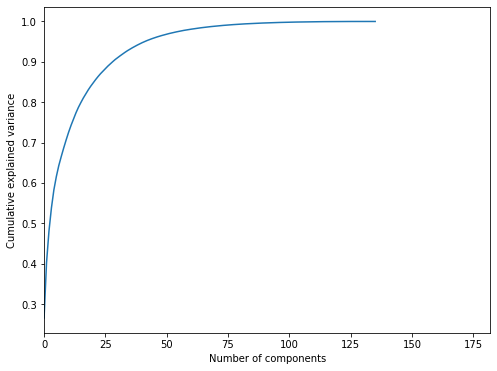

In [ ]:
pca= PCA()
pca.fit(X_eGeMAPSv02_LowLevelDescriptors)
cumsum = np.cumsum(pca.explained_variance_ratio_)
dim = np.argmax(cumsum >= 0.90) + 1
print('The number of dimensions required to preserve 90% of variance is',dim)
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,182,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [32 33 34 39 40 41] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


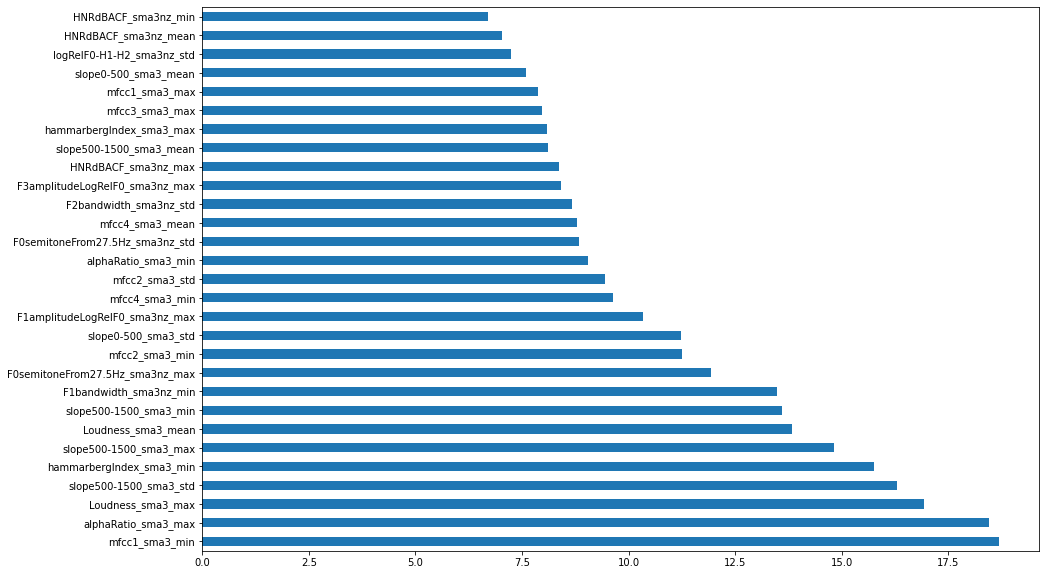

In [ ]:
select_feature = SelectKBest(f_classif, k=dim).fit(X_eGeMAPSv02_LowLevelDescriptors, y)

top_features=pd.Series(select_feature.scores_,index=X_eGeMAPSv02_LowLevelDescriptors.columns)
top_features=top_features.dropna()
plt.figure(figsize=(15, 10))
top_features.nlargest(dim).plot(kind='barh')

important_features=top_features.sort_values(ascending=False)[:5].index.tolist()
mfcc_cols = [col for col in X_eGeMAPSv02_LowLevelDescriptors.columns if 'mfcc' in col]
mfcc_and_loudness_cols = [col for col in X_eGeMAPSv02_LowLevelDescriptors.columns if ('mfcc' in col) or ('Loudness' in col)]
mfcc_and_amplitude_cols = [col for col in X_eGeMAPSv02_LowLevelDescriptors.columns if ('mfcc' in col) or ('amplitude' in col)]
mfcc_and_bandwidth_cols = [col for col in X_eGeMAPSv02_LowLevelDescriptors.columns if ('mfcc' in col) or ('bandwidth' in col)]
mfcc_and_frequency_cols = [col for col in X_eGeMAPSv02_LowLevelDescriptors.columns if ('mfcc' in col) or ('frequency' in col)]
bandwidth_frequency_amplitude_cols = [col for col in X_eGeMAPSv02_LowLevelDescriptors.columns if ('bandwidth' in col) or ('frequency' in col) or ('amplitude' in col)]

In [ ]:
cross_validated_data={'model':[],
                      'result_all':[], 
                      'result_imp':[], 
                      'result_mfcc':[],
                      'result_mfcc_and_loudness':[],
                      'result_mfcc_and_amplitude':[],
                      'result_mfcc_and_bandwidth':[],
                      'result_mfcc_and_frequency':[],
                      'result_bandwidth_frequency_amplitude':[],
                     }
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .2, train_size = .8, random_state = SEED )

In [ ]:
# For all Features
classification(X_eGeMAPSv02_LowLevelDescriptors, unScaledData__eGeMAPSv02_LowLevelDescriptors, y, 'all', cross_validated_data)

# For importnat Features
classification(X_eGeMAPSv02_LowLevelDescriptors[important_features], unScaledData__eGeMAPSv02_LowLevelDescriptors[important_features], y, 'imp', cross_validated_data)

# For MFCC Features
classification(X_eGeMAPSv02_LowLevelDescriptors[mfcc_cols], unScaledData__eGeMAPSv02_LowLevelDescriptors[mfcc_cols], y, 'mfcc', cross_validated_data)

# For mfcc_and_loudness Features
classification(X_eGeMAPSv02_LowLevelDescriptors[mfcc_and_loudness_cols], unScaledData__eGeMAPSv02_LowLevelDescriptors[mfcc_and_loudness_cols], y, 'mfcc_and_loudness', cross_validated_data)

# For mfcc_and_amplitude Features
classification(X_eGeMAPSv02_LowLevelDescriptors[mfcc_and_amplitude_cols], unScaledData__eGeMAPSv02_LowLevelDescriptors[mfcc_and_amplitude_cols],  y, 'mfcc_and_amplitude', cross_validated_data)

# For mfcc_and_bandwidth Features
classification(X_eGeMAPSv02_LowLevelDescriptors[mfcc_and_bandwidth_cols], unScaledData__eGeMAPSv02_LowLevelDescriptors[mfcc_and_bandwidth_cols], y, 'mfcc_and_bandwidth', cross_validated_data)

# For mfcc_and_frequency Features
classification(X_eGeMAPSv02_LowLevelDescriptors[mfcc_and_frequency_cols],unScaledData__eGeMAPSv02_LowLevelDescriptors[mfcc_and_frequency_cols], y, 'mfcc_and_frequency', cross_validated_data)

# For bandwidth_frequency_amplitude Features
classification(X_eGeMAPSv02_LowLevelDescriptors[bandwidth_frequency_amplitude_cols], unScaledData__eGeMAPSv02_LowLevelDescriptors[bandwidth_frequency_amplitude_cols], y, 'bandwidth_frequency_amplitude', cross_validated_data)

-----
For all features
- - - -
Applied Model:Random Forest
Best parameters {'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 200}
Mean cross-validated accuracy score of the best_estimator: 0.52
-----
-----
For all features
- - - -
Applied Model:Decision Tree
Best parameters {'max_depth': 13}
Mean cross-validated accuracy score of the best_estimator: 0.51
-----
-----
For all features
- - - -
Applied Model:SVM
Best parameters {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Mean cross-validated accuracy score of the best_estimator: 0.57
-----
-----
For all features
- - - -
Applied Model:Logistic Regression
Best parameters {'C': 1.0, 'penalty': 'l1'}
Mean cross-validated accuracy score of the best_estimator: 0.54
-----
-----
For all features
- - - -
Applied Model:KNN
Best parameters {'n_neighbors': 10, 'weights': 'uniform'}
Mean cross-validated accuracy score of the best_estimator: 0.53
-----
-----
For imp features
- - - -
Applied Model:Random Forest
Best parameter

#### Accuracy

In [ ]:
performance_df_all=pd.DataFrame(cross_validated_data['result_all'][:5],columns=['Best Parameters for All','Accuracy for All'],
                            index=cross_validated_data['model'][:5])
performance_df_all.style.set_properties(subset=['Best Parameters for All'], **{'width': '300px'})

,Best Parameters for All,Accuracy for All
Random Forest,"{'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 200}",52.000000
Decision Tree,{'max_depth': 13},51.380000
SVM,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}",56.620000
Logistic Regression,"{'C': 1.0, 'penalty': 'l1'}",54.460000
KNN,"{'n_neighbors': 10, 'weights': 'uniform'}",53.230000


In [ ]:
performance_df_mfcc=pd.DataFrame(cross_validated_data['result_mfcc'][:5],columns=['Best Parameters for MFCC','Accuracy for MFCC'],
                            index=cross_validated_data['model'][:5])
performance_df_mfcc.style.set_properties(subset=['Best Parameters for MFCC'], **{'width': '300px'})

,Best Parameters for MFCC,Accuracy for MFCC
Random Forest,"{'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 500}",54.000000
Decision Tree,{'max_depth': 11},54.150000
SVM,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}",56.150000
Logistic Regression,"{'C': 0.001, 'penalty': 'l2'}",53.380000
KNN,"{'n_neighbors': 15, 'weights': 'uniform'}",51.850000


In [ ]:
performance_df_mfcc_and_loudness=pd.DataFrame(cross_validated_data['result_mfcc_and_loudness'][:5],columns=['Best Parameters for mfcc and loudness features','Accuracy mfcc and loudness features'],
                            index=cross_validated_data['model'][:5])
performance_df_mfcc_and_loudness.style.set_properties(subset=['Best Parameters for mfcc and loudness features'], **{'width': '300px'})

,Best Parameters for mfcc and loudness features,Accuracy mfcc and loudness features
Random Forest,"{'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 500}",55.380000
Decision Tree,{'max_depth': 5},57.080000
SVM,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}",56.620000
Logistic Regression,"{'C': 1.0, 'penalty': 'l1'}",54.770000
KNN,"{'n_neighbors': 15, 'weights': 'uniform'}",52.460000


In [ ]:
performance_df_imp=pd.DataFrame(cross_validated_data['result_imp'][:5],columns=['Best Parameters for Important features','Accuracy for Important features'],
                            index=cross_validated_data['model'][:5])
performance_df_imp.style.set_properties(subset=['Best Parameters for Important features'], **{'width': '300px'})

,Best Parameters for Important features,Accuracy for Important features
Random Forest,"{'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 500}",52.620000
Decision Tree,{'max_depth': 3},52.000000
SVM,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}",55.230000
Logistic Regression,"{'C': 0.1, 'penalty': 'l1'}",55.380000
KNN,"{'n_neighbors': 15, 'weights': 'uniform'}",57.540000


In [ ]:
performance_df_mfcc_and_amplitude=pd.DataFrame(cross_validated_data['result_mfcc_and_amplitude'][:5],columns=['Best Parameters for mfcc and amplitude features','Accuracy for mfcc and amplitude features'],
                            index=cross_validated_data['model'][:5])
performance_df_mfcc_and_amplitude.style.set_properties(subset=['Best Parameters for mfcc and amplitude features'], **{'width': '300px'})

,Best Parameters for mfcc and amplitude features,Accuracy for mfcc and amplitude features
Random Forest,"{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 200}",53.380000
Decision Tree,{'max_depth': 13},54.310000
SVM,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}",55.540000
Logistic Regression,"{'C': 0.001, 'penalty': 'l2'}",54.310000
KNN,"{'n_neighbors': 10, 'weights': 'distance'}",51.850000


In [ ]:
performance_df_mfcc_and_bandwidth=pd.DataFrame(cross_validated_data['result_mfcc_and_bandwidth'][:5],columns=['Best Parameters for mfcc and bandwidth features','Accuracy for mfcc and bandwidth features'],
                            index=cross_validated_data['model'][:5])
performance_df_mfcc_and_bandwidth.style.set_properties(subset=['Best Parameters for mfcc and bandwidth features'], **{'width': '300px'})

,Best Parameters for mfcc and bandwidth features,Accuracy for mfcc and bandwidth features
Random Forest,"{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 500}",53.850000
Decision Tree,{'max_depth': 9},51.540000
SVM,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}",56.000000
Logistic Regression,"{'C': 0.1, 'penalty': 'l2'}",53.230000
KNN,"{'n_neighbors': 8, 'weights': 'uniform'}",54.920000


In [ ]:
performance_df_bandwidth_frequency_amplitude=pd.DataFrame(cross_validated_data['result_bandwidth_frequency_amplitude'][:5],columns=['Best Parameters for bandwidth,frequency and amplitude features','Accuracy for bandwidth,frequency and amplitude features'],
                            index=cross_validated_data['model'][:5])
performance_df_bandwidth_frequency_amplitude.style.set_properties(subset=['Best Parameters for bandwidth,frequency and amplitude features'], **{'width': '400px'})

,"Best Parameters for bandwidth,frequency and amplitude features","Accuracy for bandwidth,frequency and amplitude features"
Random Forest,"{'criterion': 'entropy', 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 500}",53.380000
Decision Tree,{'max_depth': 3},52.310000
SVM,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}",54.620000
Logistic Regression,"{'C': 1.0, 'penalty': 'l1'}",53.380000
KNN,"{'n_neighbors': 5, 'weights': 'uniform'}",53.850000


In [ ]:
performance_df_mfcc_and_frequency=pd.DataFrame(cross_validated_data['result_mfcc_and_frequency'][:5],columns=['Best Parameters for mfcc and frequency features','Accuracy for mfcc and frequency features'],
                            index=cross_validated_data['model'][:5])
performance_df_mfcc_and_frequency.style.set_properties(subset=['Best Parameters for mfcc and frequency features'], **{'width': '300px'})

,Best Parameters for mfcc and frequency features,Accuracy for mfcc and frequency features
Random Forest,"{'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 200}",53.690000
Decision Tree,{'max_depth': 9},51.380000
SVM,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}",55.080000
Logistic Regression,"{'C': 0.1, 'penalty': 'l2'}",54.770000
KNN,"{'n_neighbors': 20, 'weights': 'distance'}",54.770000


In [ ]:
performance_df = pd.concat([performance_df_all, performance_df_mfcc, performance_df_imp, performance_df_mfcc_and_loudness, performance_df_mfcc_and_amplitude, performance_df_mfcc_and_bandwidth, performance_df_mfcc_and_frequency, performance_df_bandwidth_frequency_amplitude], axis=1)
# performance_df.to_csv(f'{base_dir}/Audio_Accuracy_For_eGeMAPSv02_LowLevelDescriptors.csv')

### ComParE2016_LowLevelDescriptors

#### ComParE2016_LowLevelDescriptors Features Scalling

In [ ]:
columns = [column for column in df.columns if ('ComParE2016_LowLevelDescriptors' in column) or ('label' in column)]
ComParE2016_LowLevelDescriptors = df[columns]
columns = [column.replace('ComParE2016_LowLevelDescriptors__', '') for column in ComParE2016_LowLevelDescriptors.columns]
ComParE2016_LowLevelDescriptors.columns = columns
ComParE2016_LowLevelDescriptors.head()

,F0final_sma_max,voicingFinalUnclipped_sma_max,jitterLocal_sma_max,jitterDDP_sma_max,shimmerLocal_sma_max,logHNR_sma_max,audspec_lengthL1norm_sma_max,audspecRasta_lengthL1norm_sma_max,pcm_RMSenergy_sma_max,pcm_zcr_sma_max,audSpec_Rfilt_sma[0]_max,audSpec_Rfilt_sma[1]_max,audSpec_Rfilt_sma[2]_max,audSpec_Rfilt_sma[3]_max,audSpec_Rfilt_sma[4]_max,audSpec_Rfilt_sma[5]_max,audSpec_Rfilt_sma[6]_max,audSpec_Rfilt_sma[7]_max,audSpec_Rfilt_sma[8]_max,audSpec_Rfilt_sma[9]_max,audSpec_Rfilt_sma[10]_max,audSpec_Rfilt_sma[11]_max,audSpec_Rfilt_sma[12]_max,audSpec_Rfilt_sma[13]_max,audSpec_Rfilt_sma[14]_max,audSpec_Rfilt_sma[15]_max,audSpec_Rfilt_sma[16]_max,audSpec_Rfilt_sma[17]_max,audSpec_Rfilt_sma[18]_max,audSpec_Rfilt_sma[19]_max,audSpec_Rfilt_sma[20]_max,audSpec_Rfilt_sma[21]_max,audSpec_Rfilt_sma[22]_max,audSpec_Rfilt_sma[23]_max,audSpec_Rfilt_sma[24]_max,audSpec_Rfilt_sma[25]_max,pcm_fftMag_fband250-650_sma_max,pcm_fftMag_fband1000-4000_sma_max,pcm_fftMag_spectralRollOff25.0_sma_max,pcm_fftMag_spectralRollOff50.0_sma_max,...,audSpec_Rfilt_sma[16]_kurt,audSpec_Rfilt_sma[17]_kurt,audSpec_Rfilt_sma[18]_kurt,audSpec_Rfilt_sma[19]_kurt,audSpec_Rfilt_sma[20]_kurt,audSpec_Rfilt_sma[21]_kurt,audSpec_Rfilt_sma[22]_kurt,audSpec_Rfilt_sma[23]_kurt,audSpec_Rfilt_sma[24]_kurt,audSpec_Rfilt_sma[25]_kurt,pcm_fftMag_fband250-650_sma_kurt,pcm_fftMag_fband1000-4000_sma_kurt,pcm_fftMag_spectralRollOff25.0_sma_kurt,pcm_fftMag_spectralRollOff50.0_sma_kurt,pcm_fftMag_spectralRollOff75.0_sma_kurt,pcm_fftMag_spectralRollOff90.0_sma_kurt,pcm_fftMag_spectralFlux_sma_kurt,pcm_fftMag_spectralCentroid_sma_kurt,pcm_fftMag_spectralEntropy_sma_kurt,pcm_fftMag_spectralVariance_sma_kurt,pcm_fftMag_spectralSkewness_sma_kurt,pcm_fftMag_spectralKurtosis_sma_kurt,pcm_fftMag_spectralSlope_sma_kurt,pcm_fftMag_psySharpness_sma_kurt,pcm_fftMag_spectralHarmonicity_sma_kurt,mfcc_sma[1]_kurt,mfcc_sma[2]_kurt,mfcc_sma[3]_kurt,mfcc_sma[4]_kurt,mfcc_sma[5]_kurt,mfcc_sma[6]_kurt,mfcc_sma[7]_kurt,mfcc_sma[8]_kurt,mfcc_sma[9]_kurt,mfcc_sma[10]_kurt,mfcc_sma[11]_kurt,mfcc_sma[12]_kurt,mfcc_sma[13]_kurt,mfcc_sma[14]_kurt,label
0,134.11484,0.776027,0.194497,0.163663,0.461611,14.277847,0.562542,54.978480,0.043316,0.997917,13.612011,40.461400,76.531390,88.065160,89.281790,65.75053,67.51773,63.547028,49.395924,58.488636,62.050232,76.989030,103.586360,65.592530,62.543090,61.310940,51.722614,53.048910,74.002360,64.208280,42.264690,49.137695,30.368162,20.991070,13.749604,9.966891,0.179051,0.013181,645.8333,1385.4166,...,73.424796,82.406059,100.138370,98.389869,79.230428,92.854285,73.276020,69.463065,64.491522,60.538444,5.647714,6.290537,9.422972,31.783317,28.048723,41.696038,1.325222,27.083080,27.787939,31.845851,0.002702,1.609385,4.527335,7.022113,5.725074,6.719213,0.756414,0.555784,-0.134547,-0.271211,0.004552,-0.415163,-0.009546,0.385176,0.117779,0.568702,-0.083153,0.328796,0.094098,1
1,132.23239,0.763103,0.423085,0.214027,0.483871,12.721160,0.701472,29.218315,0.042808,0.997917,13.519627,29.664574,41.452847,40.815872,54.060960,44.08510,43.24525,45.300280,42.992764,40.604343,36.095455,30.093460,28.443588,31.721998,29.189196,28.462036,28.731920,27.650175,26.311758,26.295588,23.224432,18.280958,15.156066,11.157004,7.443235,4.837587,0.203440,0.035117,770.8333,1468.7500,...,50.160685,49.690034,45.853929,51.619811,53.122137,47.281657,50.104952,48.762280,37.505219,31.542852,23.240763,17.903292,15.788957,25.111772,27.666203,27.582864,0.169197,13.215776,19.543269,42.060512,0.281987,2.517694,7.546308,5.088851,15.338348,9.288540,1.183819,0.787173,1.283158,0.216492,0.078829,-0.046113,0.526820,0.450023,0.999930,-0.006269,0.376668,0.568289,0.770356,0
2,236.82156,0.827068,0.179541,0.328881,0.550836,34.526600,0.745084,31.800806,0.266578,0.997917,12.892993,30.756361,47.871685,40.541595,47.969013,45.45338,45.13377,43.754932,37.111430,39.739674,36.293670,43.260914,37.617504,32.949158,34.846474,31.461111,34.101230,28.623236,31.575754,30.618578,27.195570,23.920326,18.457842,12.674975,9.048033,6.462753,3.9367

In [ ]:
unScaledData__ComParE2016_LowLevelDescriptors = ComParE2016_LowLevelDescriptors.drop('label', axis=1)

X_ComParE2016_LowLevelDescriptors = ComParE2016_LowLevelDescriptors.drop('label', axis=1)
y = df.iloc[:, -1]

In [ ]:
scaler = StandardScaler()
scaler.fit(X_ComParE2016_LowLevelDescriptors)
scaled_features_eGeMAPSv02_Functionals = scaler.transform(X_ComParE2016_LowLevelDescriptors)
scaled_features_eGeMAPSv02_Functionals

X_ComParE2016_LowLevelDescriptors = pd.DataFrame(scaled_features_eGeMAPSv02_Functionals, columns=X_ComParE2016_LowLevelDescriptors.columns)
X_ComParE2016_LowLevelDescriptors.head()

,F0final_sma_max,voicingFinalUnclipped_sma_max,jitterLocal_sma_max,jitterDDP_sma_max,shimmerLocal_sma_max,logHNR_sma_max,audspec_lengthL1norm_sma_max,audspecRasta_lengthL1norm_sma_max,pcm_RMSenergy_sma_max,pcm_zcr_sma_max,audSpec_Rfilt_sma[0]_max,audSpec_Rfilt_sma[1]_max,audSpec_Rfilt_sma[2]_max,audSpec_Rfilt_sma[3]_max,audSpec_Rfilt_sma[4]_max,audSpec_Rfilt_sma[5]_max,audSpec_Rfilt_sma[6]_max,audSpec_Rfilt_sma[7]_max,audSpec_Rfilt_sma[8]_max,audSpec_Rfilt_sma[9]_max,audSpec_Rfilt_sma[10]_max,audSpec_Rfilt_sma[11]_max,audSpec_Rfilt_sma[12]_max,audSpec_Rfilt_sma[13]_max,audSpec_Rfilt_sma[14]_max,audSpec_Rfilt_sma[15]_max,audSpec_Rfilt_sma[16]_max,audSpec_Rfilt_sma[17]_max,audSpec_Rfilt_sma[18]_max,audSpec_Rfilt_sma[19]_max,audSpec_Rfilt_sma[20]_max,audSpec_Rfilt_sma[21]_max,audSpec_Rfilt_sma[22]_max,audSpec_Rfilt_sma[23]_max,audSpec_Rfilt_sma[24]_max,audSpec_Rfilt_sma[25]_max,pcm_fftMag_fband250-650_sma_max,pcm_fftMag_fband1000-4000_sma_max,pcm_fftMag_spectralRollOff25.0_sma_max,pcm_fftMag_spectralRollOff50.0_sma_max,...,audSpec_Rfilt_sma[15]_kurt,audSpec_Rfilt_sma[16]_kurt,audSpec_Rfilt_sma[17]_kurt,audSpec_Rfilt_sma[18]_kurt,audSpec_Rfilt_sma[19]_kurt,audSpec_Rfilt_sma[20]_kurt,audSpec_Rfilt_sma[21]_kurt,audSpec_Rfilt_sma[22]_kurt,audSpec_Rfilt_sma[23]_kurt,audSpec_Rfilt_sma[24]_kurt,audSpec_Rfilt_sma[25]_kurt,pcm_fftMag_fband250-650_sma_kurt,pcm_fftMag_fband1000-4000_sma_kurt,pcm_fftMag_spectralRollOff25.0_sma_kurt,pcm_fftMag_spectralRollOff50.0_sma_kurt,pcm_fftMag_spectralRollOff75.0_sma_kurt,pcm_fftMag_spectralRollOff90.0_sma_kurt,pcm_fftMag_spectralFlux_sma_kurt,pcm_fftMag_spectralCentroid_sma_kurt,pcm_fftMag_spectralEntropy_sma_kurt,pcm_fftMag_spectralVariance_sma_kurt,pcm_fftMag_spectralSkewness_sma_kurt,pcm_fftMag_spectralKurtosis_sma_kurt,pcm_fftMag_spectralSlope_sma_kurt,pcm_fftMag_psySharpness_sma_kurt,pcm_fftMag_spectralHarmonicity_sma_kurt,mfcc_sma[1]_kurt,mfcc_sma[2]_kurt,mfcc_sma[3]_kurt,mfcc_sma[4]_kurt,mfcc_sma[5]_kurt,mfcc_sma[6]_kurt,mfcc_sma[7]_kurt,mfcc_sma[8]_kurt,mfcc_sma[9]_kurt,mfcc_sma[10]_kurt,mfcc_sma[11]_kurt,mfcc_sma[12]_kurt,mfcc_sma[13]_kurt,mfcc_sma[14]_kurt
0,-0.631600,-0.212587,-0.907990,-0.757658,-1.071789,-0.837827,-0.345821,1.968008,-0.327664,2.130407,1.480072,1.967144,2.355844,2.029848,1.486309,1.022168,1.416056,1.591710,1.201774,1.667412,1.541559,1.921692,3.427581,1.921205,1.611339,1.708089,1.457735,1.877499,2.654105,2.455253,1.900660,3.060938,1.766384,1.701542,1.158943,1.010557,-0.323535,-0.298750,-0.255762,-0.179038,...,-0.176760,-0.245310,0.041633,0.695751,0.687714,0.423156,1.198436,0.852331,0.674163,0.672613,0.977164,-0.353608,-0.686301,-0.288796,0.065764,-0.181638,0.878153,-0.103883,0.773616,0.276861,0.065615,-0.415075,-0.476759,-0.213533,-0.345894,-0.248676,1.004909,-0.432401,-0.480447,-0.916353,-1.096420,-0.677058,-1.055695,-1.102769,-0.566449,-1.083967,-0.150114,-1.156491,-0.531916,-0.626173
1,-0.648681,-0.615893,0.991155,-0.526044,-0.924547,-1.246664,-0.103448,0.534727,-0.332193,2.130407,1.461080,1.161680,0.877018,0.507388,0.605541,0.428410,0.595277,0.846833,0.891867,0.781844,0.469949,0.161377,0.175488,0.376585,0.217942,0.217949,0.315287,0.378377,0.226964,0.295668,0.414653,0.327856,0.278266,0.196006,-0.086773,-0.247849,-0.319508,-0.265540,-0.177084,-0.131484,...,-0.811921,-0.759288,-0.714175,-0.647281,-0.479630,-0.266441,-0.123198,0.101866,0.037795,-0.254359,-0.209292,0.036019,-0.434451,-0.111423,-0.072052,-0.192538,0.202818,-0.178712,-0.223588,0.104374,0.555143,-0.355098,-0.434227,-0.131586,-0.541650,0.021808,1.725071,-0.154056,-0.279449,0.121745,-0.544555,-0.605015,-0.723013,-0.264263,-0.477028,0.327347,-0.747004,-0.451256,-0.127433,0.604262
2,0.300377,1.380240,-1.032250,0.002147,-0.481584,4.480161,-0.027363,0.678415,1.663539,2.130407,1.332254,1.243130,1.147621,0.498550,0.453199,0.465909,0.659138,0.783748,0.607217,0.739028,0.478133,0.655642,0.572525,0.432548,0.454281,0.353997,0.582098,0.435810,0.494867,0.541914,0.724582,0.827354,0.601261,0.428398,0.230228,0.150863,0.296913,-0.

#### Accuracy of eGeMAPSv02_LowLevelDescriptors Features

In [ ]:
corr_features = correlation(X_ComParE2016_LowLevelDescriptors, 0.9)
print(corr_features,len(corr_features))
X_ComParE2016_LowLevelDescriptors=X_ComParE2016_LowLevelDescriptors.drop(corr_features,axis=1)
unScaledData__ComParE2016_LowLevelDescriptors=unScaledData__ComParE2016_LowLevelDescriptors.drop(corr_features,axis=1)
print(len(X_ComParE2016_LowLevelDescriptors.columns))
print(len(unScaledData__ComParE2016_LowLevelDescriptors.columns))

{'pcm_fftMag_spectralSlope_sma_std', 'audSpec_Rfilt_sma[2]_kurt', 'mfcc_sma[3]_median', 'audSpec_Rfilt_sma[4]_skew', 'jitterLocal_sma_per50', 'pcm_fftMag_spectralRollOff90.0_sma_per25', 'pcm_fftMag_spectralFlux_sma_per75', 'audSpec_Rfilt_sma[18]_mean', 'audSpec_Rfilt_sma[11]_skew', 'pcm_fftMag_fband250-650_sma_median', 'audSpec_Rfilt_sma[16]_min', 'pcm_RMSenergy_sma_min', 'mfcc_sma[13]_median', 'audSpec_Rfilt_sma[23]_max', 'audSpec_Rfilt_sma[1]_per25', 'pcm_fftMag_spectralRollOff90.0_sma_mean', 'pcm_fftMag_psySharpness_sma_median', 'audSpec_Rfilt_sma[16]_kurt', 'audSpec_Rfilt_sma[17]_max', 'audSpec_Rfilt_sma[18]_kurt', 'pcm_fftMag_spectralCentroid_sma_median', 'audSpec_Rfilt_sma[17]_per75', 'audSpec_Rfilt_sma[15]_var', 'mfcc_sma[10]_median', 'pcm_fftMag_spectralRollOff75.0_sma_per75', 'audSpec_Rfilt_sma[2]_per75', 'pcm_fftMag_spectralCentroid_sma_per75', 'pcm_zcr_sma_per25', 'mfcc_sma[11]_per50', 'audSpec_Rfilt_sma[6]_skew', 'audSpec_Rfilt_sma[18]_min', 'pcm_fftMag_spectralCentroid_sma

The number of dimensions required to preserve 90% of variance is 42


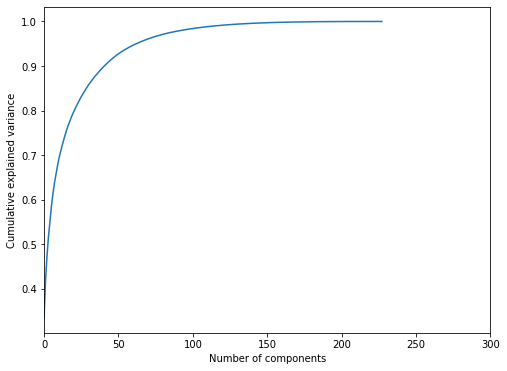

In [ ]:
pca= PCA()
pca.fit(X_ComParE2016_LowLevelDescriptors)
cumsum = np.cumsum(pca.explained_variance_ratio_)
dim = np.argmax(cumsum >= 0.90) + 1
print('The number of dimensions required to preserve 90% of variance is',dim)
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,300,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [ ]:
# X_ComParE2016_LowLevelDescriptors.columns.tolist()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [29 31 32 33 34] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


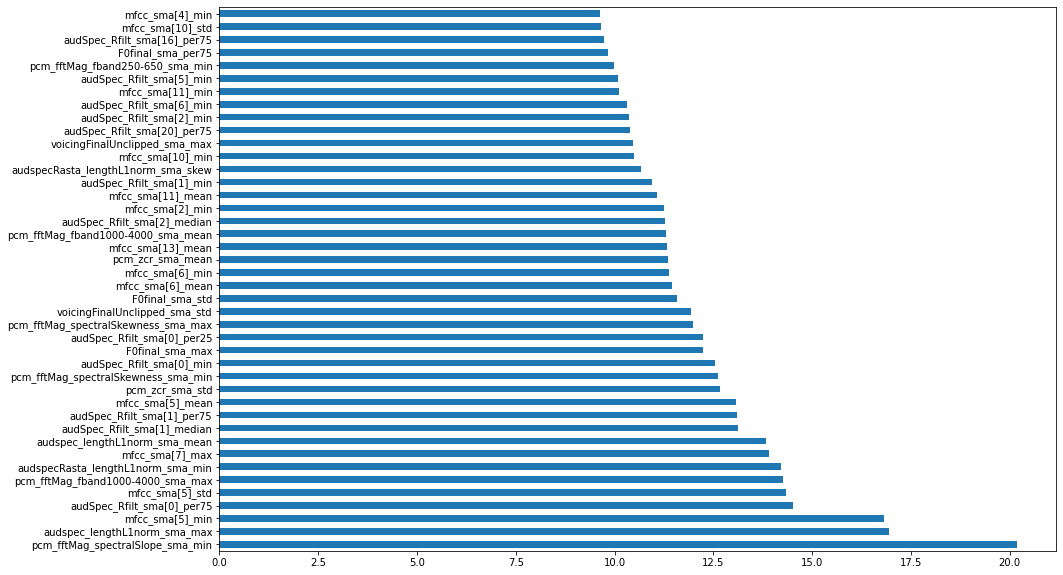

In [ ]:
select_feature = SelectKBest(f_classif, k=dim).fit(X_ComParE2016_LowLevelDescriptors, y)

top_features=pd.Series(select_feature.scores_,index=X_ComParE2016_LowLevelDescriptors.columns)
top_features=top_features.dropna()
plt.figure(figsize=(15, 10))
top_features.nlargest(dim).plot(kind='barh')

important_features=top_features.sort_values(ascending=False)[:5].index.tolist()
mfcc_cols = [col for col in X_ComParE2016_LowLevelDescriptors.columns if 'mfcc' in col]
mfcc_and_audSpec_cols = [col for col in X_ComParE2016_LowLevelDescriptors.columns if ('mfcc' in col) or ('audSpec' in col)]
mfcc_and_pcm_fftMag_cols = [col for col in X_ComParE2016_LowLevelDescriptors.columns if ('mfcc' in col) or ('pcm_fftMag' in col)]
audSpec_and_pcm_fftMag_cols = [col for col in X_ComParE2016_LowLevelDescriptors.columns if ('audSpec' in col) or ('pcm_fftMag' in col)]

In [ ]:
cross_validated_data={'model':[],
                      'result_all':[], 
                      'result_imp':[], 
                      'result_mfcc':[],
                      'result_mfcc_and_audSpec':[],
                      'result_mfcc_and_pcm_fftMag':[],
                      'result_audSpec_and_pcm_fftMag':[],
                     }
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .2, train_size = .8, random_state = SEED )

In [ ]:
# For all Features
classification(X_ComParE2016_LowLevelDescriptors, unScaledData__ComParE2016_LowLevelDescriptors, y, 'all', cross_validated_data)

# For important Features
classification(X_ComParE2016_LowLevelDescriptors[important_features], unScaledData__ComParE2016_LowLevelDescriptors[important_features], y, 'imp', cross_validated_data)

# For MFCC Features
classification(X_ComParE2016_LowLevelDescriptors[mfcc_cols], unScaledData__ComParE2016_LowLevelDescriptors[mfcc_cols], y, 'mfcc', cross_validated_data)

# For mfcc_and_audSpec Features
classification(X_ComParE2016_LowLevelDescriptors[mfcc_and_audSpec_cols], unScaledData__ComParE2016_LowLevelDescriptors[mfcc_and_audSpec_cols], y, 'mfcc_and_audSpec', cross_validated_data)

# For mfcc_and_pcm_fftMag Features
classification(X_ComParE2016_LowLevelDescriptors[mfcc_and_pcm_fftMag_cols], unScaledData__ComParE2016_LowLevelDescriptors[mfcc_and_pcm_fftMag_cols],  y, 'mfcc_and_pcm_fftMag', cross_validated_data)

# For audSpec_and_pcm_fftMag Features
classification(X_ComParE2016_LowLevelDescriptors[audSpec_and_pcm_fftMag_cols], unScaledData__ComParE2016_LowLevelDescriptors[audSpec_and_pcm_fftMag_cols], y, 'audSpec_and_pcm_fftMag', cross_validated_data)

-----
For all features
- - - -
Applied Model:Random Forest
Best parameters {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 500}
Mean cross-validated accuracy score of the best_estimator: 0.55
-----
-----
For all features
- - - -
Applied Model:Decision Tree
Best parameters {'max_depth': 3}
Mean cross-validated accuracy score of the best_estimator: 0.53
-----
-----
For all features
- - - -
Applied Model:SVM
Best parameters {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Mean cross-validated accuracy score of the best_estimator: 0.57
-----
-----
For all features
- - - -
Applied Model:Logistic Regression
Best parameters {'C': 1.0, 'penalty': 'l2'}
Mean cross-validated accuracy score of the best_estimator: 0.55
-----
-----
For all features
- - - -
Applied Model:KNN
Best parameters {'n_neighbors': 13, 'weights': 'distance'}
Mean cross-validated accuracy score of the best_estimator: 0.54
-----
-----
For imp features
- - - -
Applied Model:Random Forest
Best parameter

#### Accuracy

In [ ]:
performance_df_all=pd.DataFrame(cross_validated_data['result_all'][:5],columns=['Best Parameters for All','Accuracy for All'],
                            index=cross_validated_data['model'][:5])
performance_df_all.style.set_properties(subset=['Best Parameters for All'], **{'width': '300px'})

,Best Parameters for All,Accuracy for All
Random Forest,"{'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 500}",54.620000
Decision Tree,{'max_depth': 3},53.080000
SVM,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}",57.230000
Logistic Regression,"{'C': 1.0, 'penalty': 'l2'}",55.230000
KNN,"{'n_neighbors': 13, 'weights': 'distance'}",54.310000


In [ ]:
performance_df_imp=pd.DataFrame(cross_validated_data['result_imp'][:5],columns=['Best Parameters for Important features','Accuracy for Important features'],
                            index=cross_validated_data['model'][:5])
performance_df_imp.style.set_properties(subset=['Best Parameters for Important features'], **{'width': '300px'})

,Best Parameters for Important features,Accuracy for Important features
Random Forest,"{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}",54.310000
Decision Tree,{'max_depth': 13},56.310000
SVM,"{'C': 1.0, 'gamma': 'auto', 'kernel': 'sigmoid'}",56.460000
Logistic Regression,"{'C': 0.1, 'penalty': 'l1'}",55.850000
KNN,"{'n_neighbors': 15, 'weights': 'distance'}",54.620000


In [ ]:
performance_df_mfcc=pd.DataFrame(cross_validated_data['result_mfcc'][:5],columns=['Best Parameters for MFCC','Accuracy for MFCC'],
                            index=cross_validated_data['model'][:5])
performance_df_mfcc.style.set_properties(subset=['Best Parameters for MFCC'], **{'width': '300px'})

,Best Parameters for MFCC,Accuracy for MFCC
Random Forest,"{'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200}",54.000000
Decision Tree,{'max_depth': 5},54.000000
SVM,"{'C': 0.001, 'gamma': 'scale', 'kernel': 'linear'}",55.080000
Logistic Regression,"{'C': 0.01, 'penalty': 'l2'}",54.770000
KNN,"{'n_neighbors': 25, 'weights': 'uniform'}",55.230000


In [ ]:
performance_df_mfcc_and_audSpec=pd.DataFrame(cross_validated_data['result_mfcc_and_audSpec'][:5],columns=['Best Parameters for mfcc and audSpec features','Accuracy mfcc and audSpec features'],
                            index=cross_validated_data['model'][:5])
performance_df_mfcc_and_audSpec.style.set_properties(subset=['Best Parameters for mfcc and audSpec features'], **{'width': '300px'})

,Best Parameters for mfcc and audSpec features,Accuracy mfcc and audSpec features
Random Forest,"{'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 200}",53.540000
Decision Tree,{'max_depth': 5},54.000000
SVM,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}",56.310000
Logistic Regression,"{'C': 1.0, 'penalty': 'l1'}",56.000000
KNN,"{'n_neighbors': 25, 'weights': 'uniform'}",54.460000


In [ ]:
performance_df_mfcc_and_pcm_fftMag=pd.DataFrame(cross_validated_data['result_mfcc_and_pcm_fftMag'][:5],columns=['Best Parameters for mfcc and pcm_fftMag features','Accuracy for mfcc and pcm_fftMag features'],
                            index=cross_validated_data['model'][:5])
performance_df_mfcc_and_pcm_fftMag.style.set_properties(subset=['Best Parameters for mfcc and pcm_fftMag features'], **{'width': '300px'})

,Best Parameters for mfcc and pcm_fftMag features,Accuracy for mfcc and pcm_fftMag features
Random Forest,"{'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 500}",54.620000
Decision Tree,{'max_depth': 3},54.310000
SVM,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}",58.000000
Logistic Regression,"{'C': 0.01, 'penalty': 'l2'}",55.690000
KNN,"{'n_neighbors': 20, 'weights': 'uniform'}",55.080000


In [ ]:
performance_df_audSpec_and_pcm_fftMag=pd.DataFrame(cross_validated_data['result_audSpec_and_pcm_fftMag'][:5],columns=['Best Parameters for audSpec and pcm_fftMag features','Accuracy for audSpec and pcm_fftMag features'],
                            index=cross_validated_data['model'][:5])
performance_df_audSpec_and_pcm_fftMag.style.set_properties(subset=['Best Parameters for audSpec and pcm_fftMag features'], **{'width': '300px'})

,Best Parameters for audSpec and pcm_fftMag features,Accuracy for audSpec and pcm_fftMag features
Random Forest,"{'criterion': 'entropy', 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 200}",56.620000
Decision Tree,{'max_depth': 11},53.540000
SVM,"{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}",59.080000
Logistic Regression,"{'C': 0.001, 'penalty': 'l2'}",55.230000
KNN,"{'n_neighbors': 25, 'weights': 'distance'}",59.080000


In [ ]:
performance_df = pd.concat([performance_df_all, performance_df_mfcc, performance_df_imp, performance_df_mfcc_and_audSpec, performance_df_mfcc_and_pcm_fftMag, performance_df_audSpec_and_pcm_fftMag], axis=1)
# performance_df.to_csv(f'{base_dir}/Audio_Accuracy_For_ComParE2016_LowLevelDescriptors.csv')

### Accuracy Analysis

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
def evaluate_preds(X_vals,y_val,clfs, metric_dict, label):
    for i, X_val in enumerate(X_vals):
        for j, clf in enumerate(clfs):
            if (i == j):
                precision=cross_val_score(clf, X_val, y_val, 
                    cv=cv_split,scoring='precision').mean()
                recall=cross_val_score(clf, X_val, y_val, 
                    cv=cv_split,scoring='recall').mean()
                f1=cross_val_score(clf, X_val, y_val, 
                    cv=cv_split,scoring='f1').mean()
                # metric_dict[f'{label}_precision']= round(precision*100,2),
                # metric_dict[f"{label}_recall"] = round(recall*100,2),
                # metric_dict[f"{label}_f1"] = round(f1*100,2)

In [ ]:
accuray_df1 = pd.read_csv(f'{base_dir}/Audio_Accuracy_For_eGeMAPSv02_Functionals_without_correlation.csv')
accuray_df1.set_index('Unnamed: 0', inplace=True)
accuray_df1.index.name = 'eGeMAPSv02_Functionals_without_correlation'

In [ ]:
# Best_Parameters_columns = [column for column in accuray_df1.columns if 'Best Parameters' in column]
# Best_Parameters_df = accuray_df1[Best_Parameters_columns]
# columns = [column.replace('Best Parameters for ', '') for column in Best_Parameters_columns]
# Best_Parameters_df.columns = columns

# all = Best_Parameters_df['All'].tolist()
# mfcc = Best_Parameters_df['MFCC'].tolist()

# # For All
# validateds = []
# for dic in all:
#     validated = RandomForestClassifier()
#     validateds.append(validated)
# validateds[0]

# values = []
# for index in range(len(all)):
#     if index > 1:
#         values.append(X_eGeMAPSv02_Functionals.values)
#     else:
#       values.append(unScaledData__eGeMAPSv02_Functionals.values)

# metric_dict1 = {}
# evaluate_preds(values, y.values, validateds, metric_dict1, 'all')

In [ ]:
Best_Parameters_columns = [column for column in accuray_df1.columns if 'Best Parameters' in column]
accuray_df1_acc = accuray_df1.drop(Best_Parameters_columns, axis=1)

columns = [column.replace('Accuracy for ', '') for column in accuray_df1.columns if 'Accuracy' in column]
accuray_df1_acc.columns = columns
accuray_df1_acc

,All,MFCC,Important features,Accuracy mfcc and loudness features,mfcc and amplitude features,mfcc and bandwidth features,mfcc and frequency features,"bandwidth,frequency and amplitude features"
eGeMAPSv02_Functionals_without_correlation,,,,,,,,
Random Forest,52.77,52.31,59.85,54.92,52.15,52.46,51.69,52.00
Decision Tree,55.08,54.77,55.69,54.62,52.92,50.46,55.69,52.46
SVM,56.77,55.85,56.92,58.00,56.00,55.23,56.77,54.92
Logistic Regression,54.31,54.62,56.77,56.46,54.00,52.15,57.23,52.15
KNN,54.00,55.08,52.92,54.62,57.38,55.54,56.15,53.38


Text(0.5, 0, 'Algorithm')

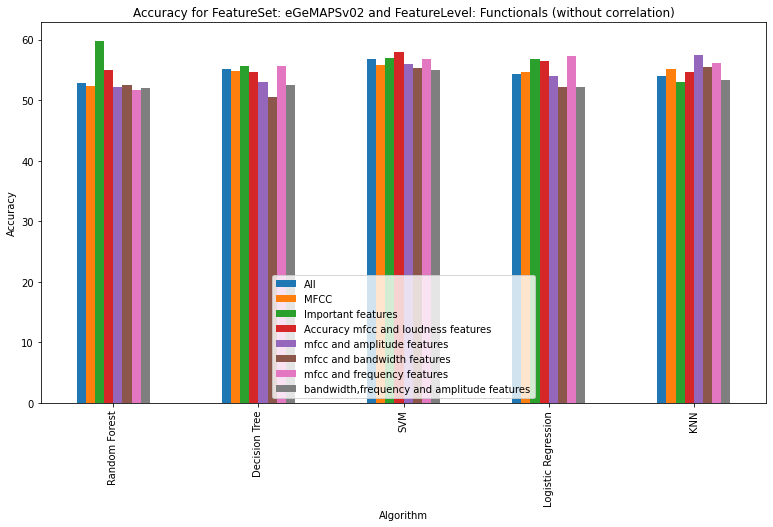

In [ ]:
ax = accuray_df1_acc.plot(kind="bar", figsize=(13, 7))
plt.title("Accuracy for FeatureSet: eGeMAPSv02 and FeatureLevel: Functionals (without correlation)")
plt.ylabel("Accuracy")
plt.xlabel("Algorithm")

In [ ]:
accuray_df2 = pd.read_csv(f'{base_dir}/Audio_Accuracy_For_eGeMAPSv02_Functionals_with_correlation.csv')
accuray_df2.set_index('Unnamed: 0', inplace=True)
accuray_df2.index.name = 'eGeMAPSv02_Functionals_with_correlation'

In [ ]:
Best_Parameters_columns = [column for column in accuray_df2.columns if 'Best Parameters' in column]
accuray_df2_acc = accuray_df2.drop(Best_Parameters_columns, axis=1)

columns = [column.replace('Accuracy for ', '') for column in accuray_df2.columns if 'Accuracy' in column]
accuray_df2_acc.columns = columns
accuray_df2_acc

,All,MFCC,Important features,Accuracy mfcc and loudness features,mfcc and amplitude features,mfcc and bandwidth features,mfcc and frequency features,"bandwidth,frequency and amplitude features"
eGeMAPSv02_Functionals_with_correlation,,,,,,,,
Random Forest,53.54,51.38,58.46,54.62,52.46,52.46,51.38,52.62
Decision Tree,55.23,56.46,59.08,54.31,56.46,53.23,54.62,53.69
SVM,57.08,56.46,57.54,56.15,55.38,54.92,56.46,53.54
Logistic Regression,54.31,54.77,59.23,54.77,54.15,52.15,56.31,52.15
KNN,53.54,55.85,58.77,56.46,58.46,54.46,55.08,53.69


Text(0.5, 0, 'Algorithm')

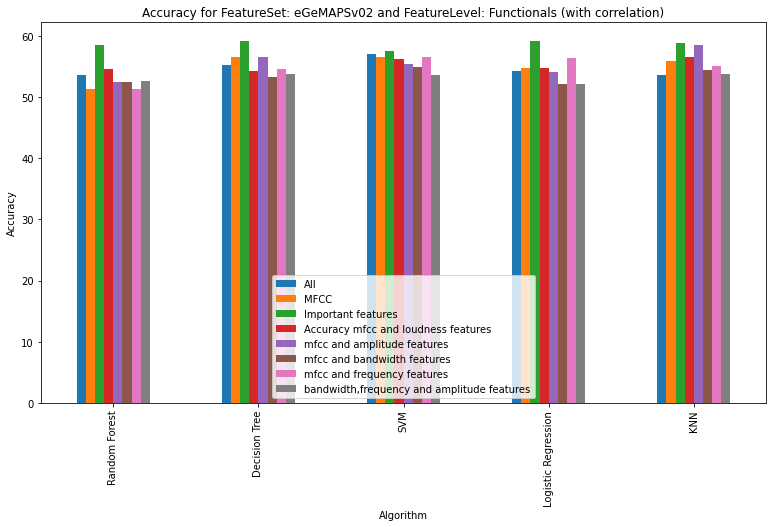

In [ ]:
accuray_df2_acc.plot(kind="bar", figsize=(13, 7))
plt.title("Accuracy for FeatureSet: eGeMAPSv02 and FeatureLevel: Functionals (with correlation)")
plt.ylabel("Accuracy")
plt.xlabel("Algorithm")

In [ ]:
accuray_df3 = pd.read_csv(f'{base_dir}/Audio_Accuracy_For_eGeMAPSv02_LowLevelDescriptors.csv')
accuray_df3.set_index('Unnamed: 0', inplace=True)
accuray_df3.index.name = 'eGeMAPSv02_LowLevelDescriptors'

In [ ]:
Best_Parameters_columns = [column for column in accuray_df3.columns if 'Best Parameters' in column]
accuray_df3_acc = accuray_df3.drop(Best_Parameters_columns, axis=1)

columns = [column.replace('Accuracy for ', '') for column in accuray_df3.columns if 'Accuracy' in column]
accuray_df3_acc.columns = columns
accuray_df3_acc

,All,MFCC,Important features,Accuracy mfcc and loudness features,mfcc and amplitude features,mfcc and bandwidth features,mfcc and frequency features,"bandwidth,frequency and amplitude features"
eGeMAPSv02_LowLevelDescriptors,,,,,,,,
Random Forest,52.00,54.00,52.62,55.38,53.38,53.85,53.69,53.38
Decision Tree,51.38,54.15,52.00,57.08,54.31,51.54,51.38,52.31
SVM,56.62,56.15,55.23,56.62,55.54,56.00,55.08,54.62
Logistic Regression,54.46,53.38,55.38,54.77,54.31,53.23,54.77,53.38
KNN,53.23,51.85,57.54,52.46,51.85,54.92,54.77,53.85


Text(0.5, 0, 'Algorithm')

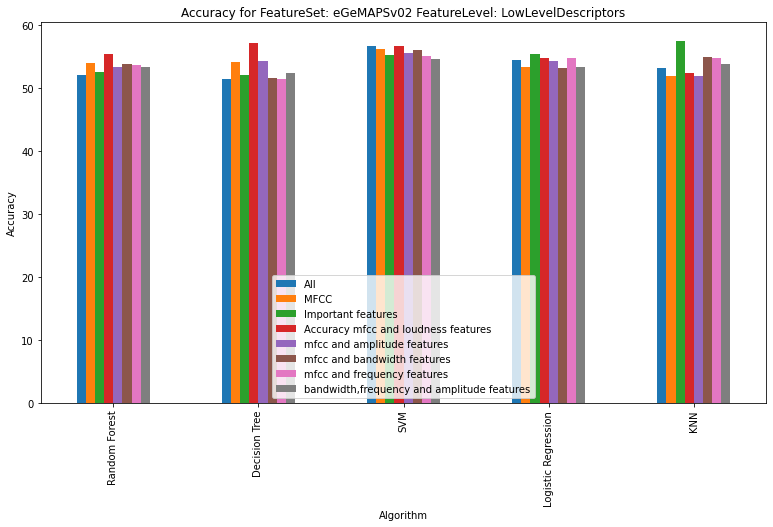

In [ ]:
accuray_df3_acc.plot(kind="bar", figsize=(13, 7))
plt.title("Accuracy for FeatureSet: eGeMAPSv02 FeatureLevel: LowLevelDescriptors")
plt.ylabel("Accuracy")
plt.xlabel("Algorithm")

In [ ]:
accuray_df4 = pd.read_csv(f'{base_dir}/Audio_Accuracy_For_ComParE2016_LowLevelDescriptors.csv')
accuray_df4.set_index('Unnamed: 0', inplace=True)
accuray_df4.index.name = 'ComParE2016_LowLevelDescriptors'

In [ ]:
Best_Parameters_columns = [column for column in accuray_df4.columns if 'Best Parameters' in column]
accuray_df4_acc = accuray_df4.drop(Best_Parameters_columns, axis=1)

columns = [column.replace('Accuracy for ', '') for column in accuray_df4.columns if 'Accuracy' in column]
accuray_df4_acc.columns = columns
accuray_df4_acc

,All,MFCC,Important features,Accuracy mfcc and audSpec features,mfcc and pcm_fftMag features,audSpec and pcm_fftMag features
ComParE2016_LowLevelDescriptors,,,,,,
Random Forest,54.62,54.00,54.31,53.54,54.62,56.62
Decision Tree,53.08,54.00,56.31,54.00,54.31,53.54
SVM,57.23,55.08,56.46,56.31,58.00,59.08
Logistic Regression,55.23,54.77,55.85,56.00,55.69,55.23
KNN,54.31,55.23,54.62,54.46,55.08,59.08


Text(0.5, 0, 'Algorithm')

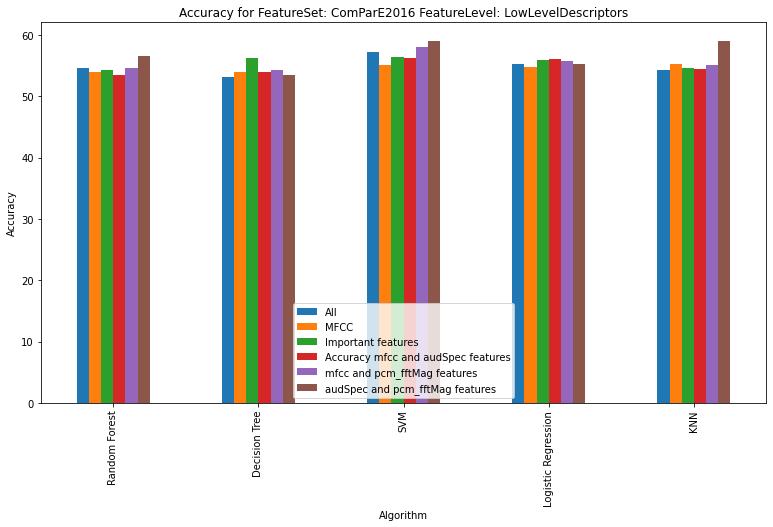

In [ ]:
accuray_df4_acc.plot(kind="bar", figsize=(13, 7))
plt.title("Accuracy for FeatureSet: ComParE2016 FeatureLevel: LowLevelDescriptors")
plt.ylabel("Accuracy")
plt.xlabel("Algorithm")